In [ ]:
#| hide
import sys
sys.path.append("/notebooks/katlas")
from nbdev.showdoc import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
from fastbook import *
from katlas.core import *
from katlas.train import *
from katlas.plot import *
from sklearn.model_selection import StratifiedGroupKFold
import seaborn as sns

In [ ]:
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

# Baseline: one-hot encoded a.a. & kinase

> Use only one-hot encoded categories to train

## Prepare dataset

We can encode both a.a. and kinase in one-hot, and with only additional position info, we can see how the model may "remember" some info.

In [ ]:
# target = Data.get_standard_unstack()

In [ ]:
target = Data.get_log_unstack()

In [ ]:
target.shape

(59994, 5)

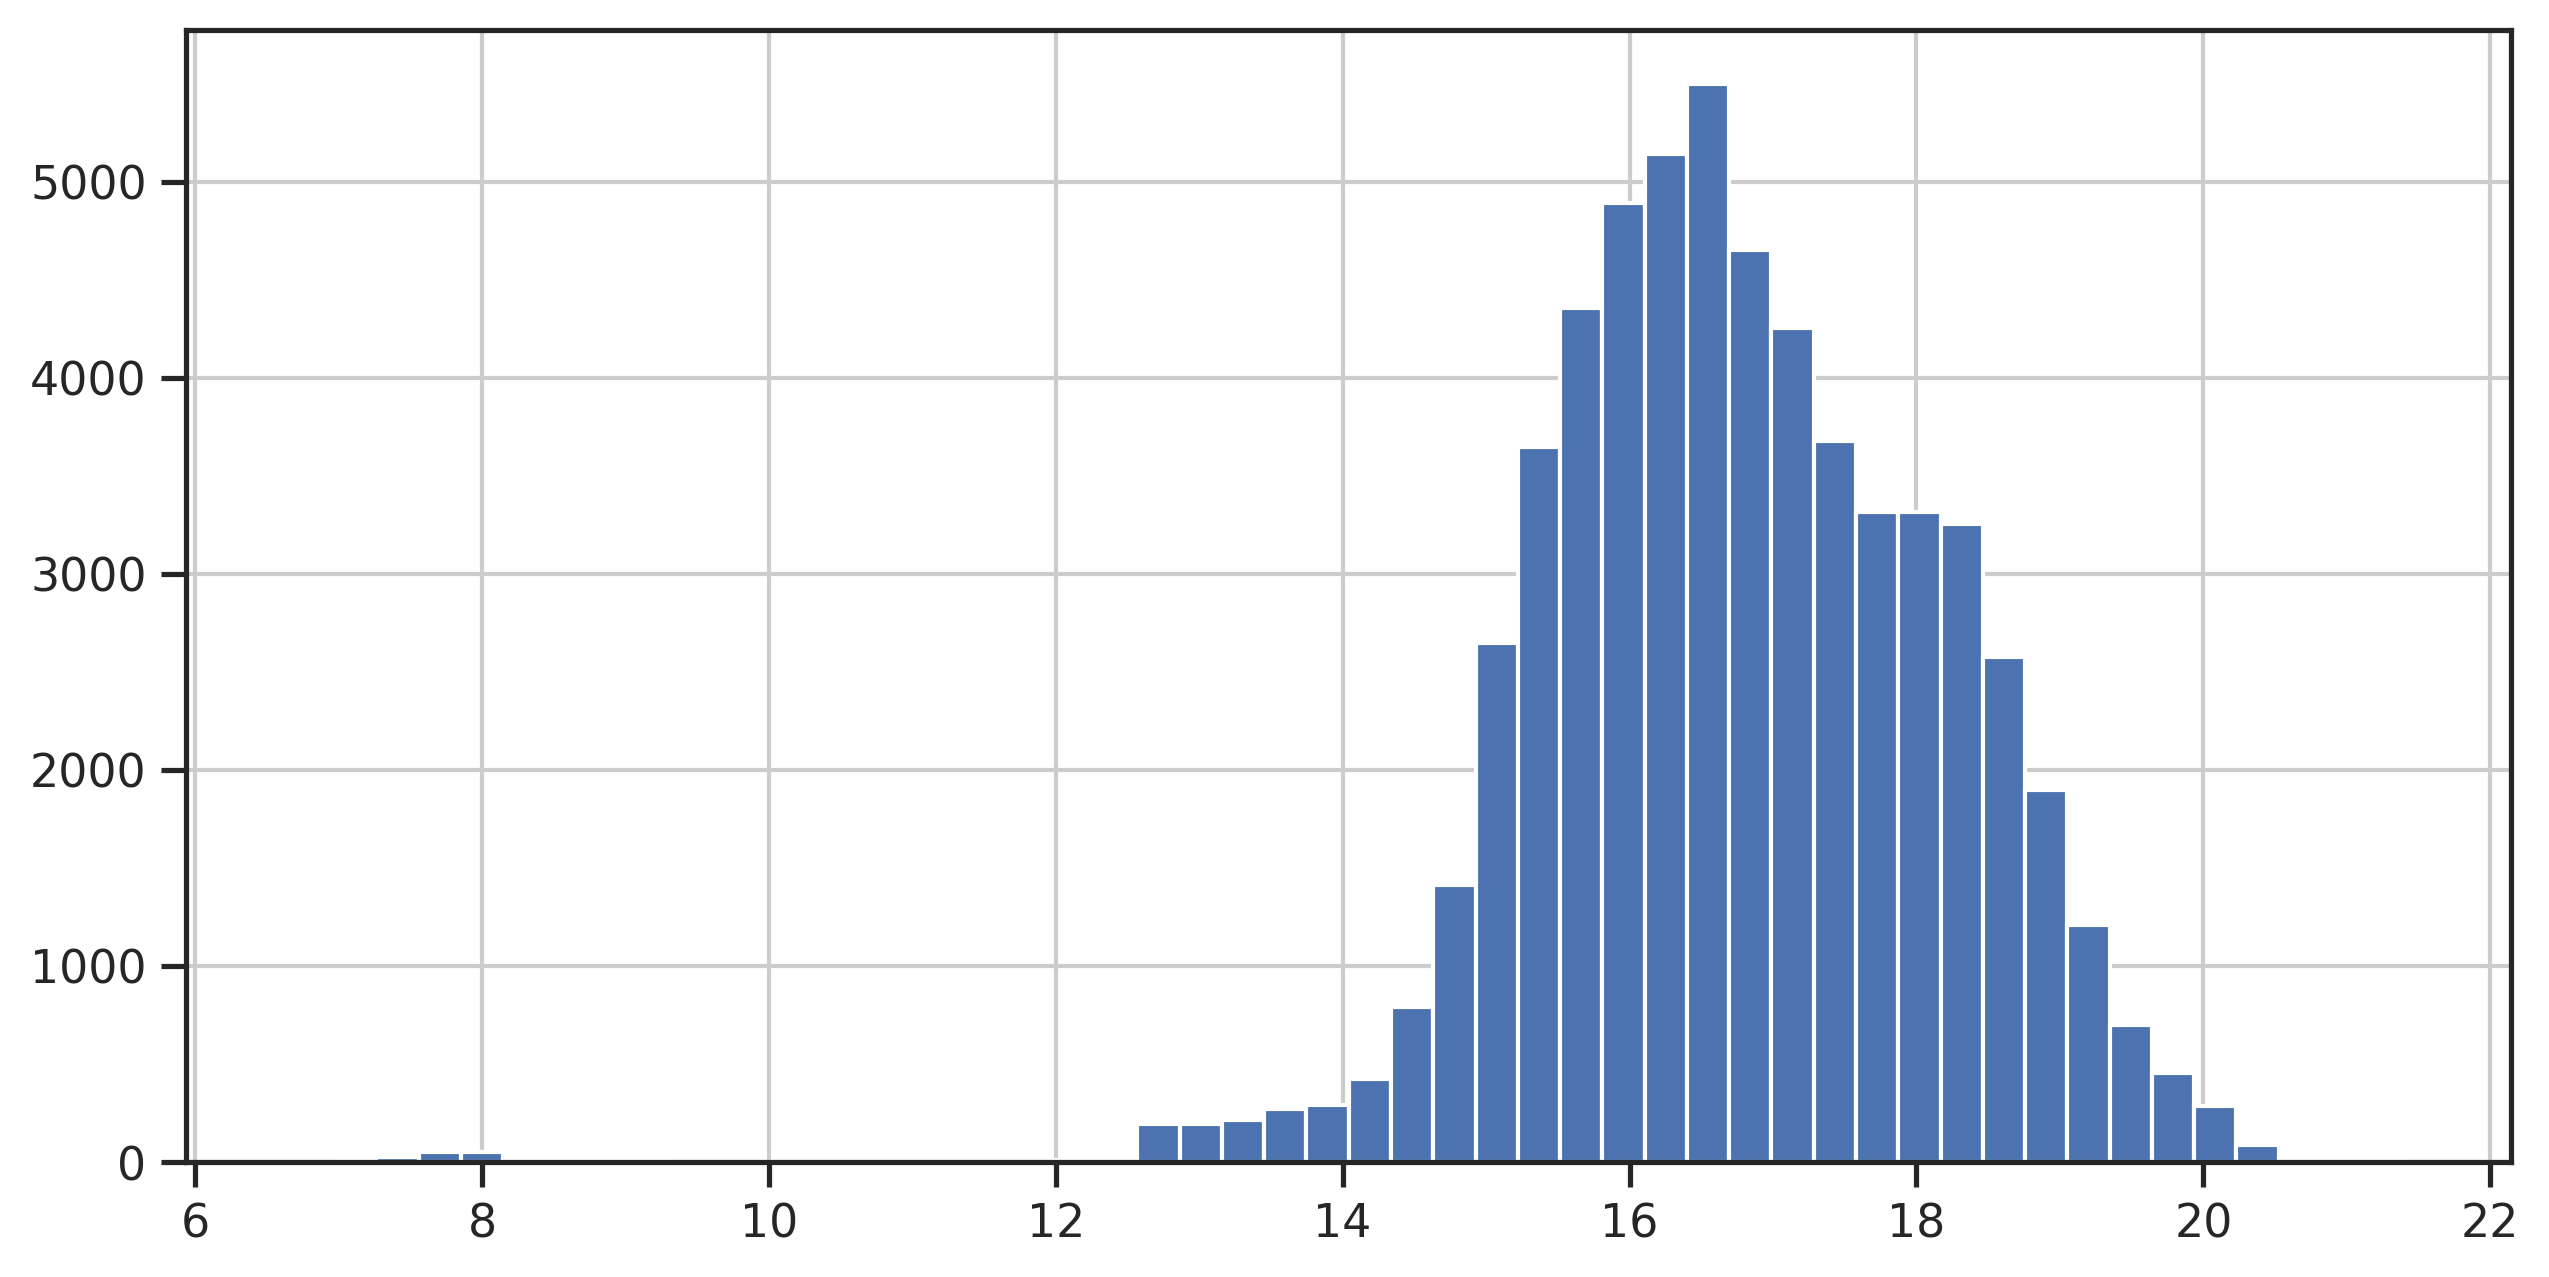

In [ ]:
target.target.hist(bins=50,figsize=(10,5));

We can remove outliers

In [ ]:
target = target.query('kinase != "CK1G2" ').reset_index(drop=True)

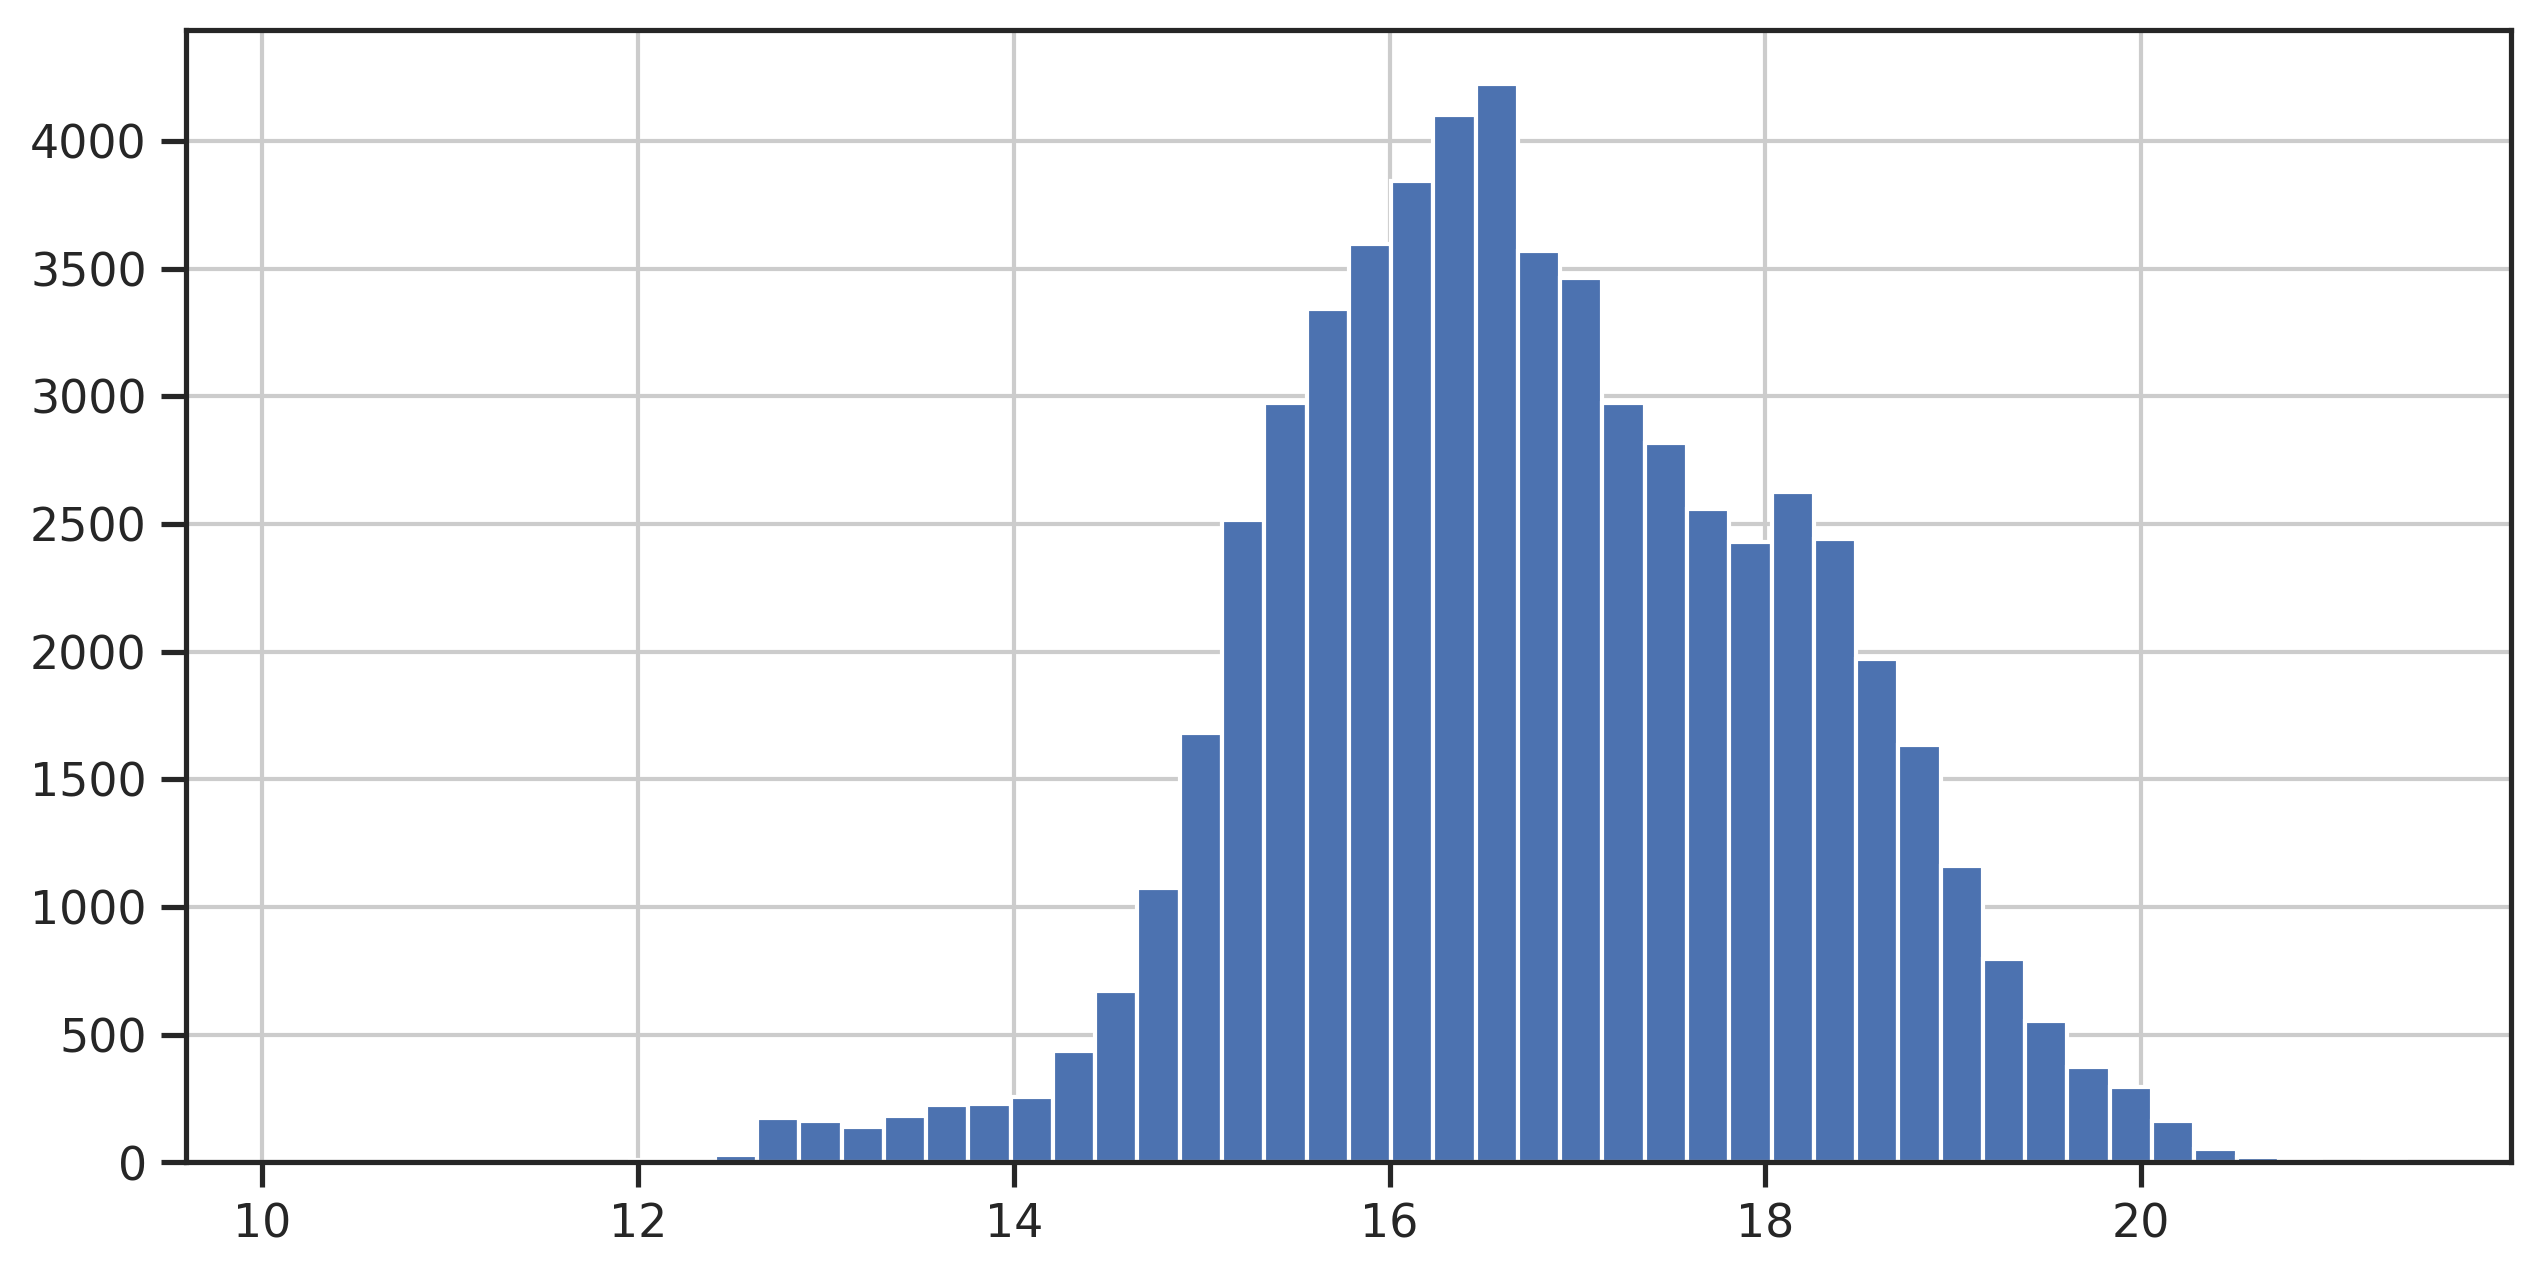

In [ ]:
target.target.hist(bins=50,figsize=(10,5));

### Get dummies

In [ ]:
# Get dummies
aa_one = pd.get_dummies(target.aa)

In [ ]:
kinase_one = pd.get_dummies(target.kinase)

### Concatenate all together

In [ ]:
df = pd.concat([target,aa_one],axis=1)

In [ ]:
df = pd.concat([df,kinase_one],axis=1)

In [ ]:
df.head()

,kinase,substrate,target,position,aa,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y,t,y,AAK1,ACVR2A,ACVR2B,AKT1,AKT2,AKT3,ALK2,ALK4,ALPHAK3,AMPKA1,AMPKA2,ANKRD3,ASK1,ATM,ATR,AURA,AURB,AURC,BCKDK,BIKE,BMPR1A,BMPR1B,BMPR2,BRAF,BRSK1,BRSK2,BUB1,CAMK1A,CAMK1B,CAMK1D,CAMK1G,CAMK2A,CAMK2B,CAMK2D,CAMK2G,CAMK4,CAMKK1,CAMKK2,CAMLCK,CDC7,CDK1,CDK10,CDK12,CDK13,CDK14,CDK16,CDK17,CDK18,CDK19,CDK2,CDK3,CDK4,CDK5,CDK6,CDK7,CDK8,CDK9,CDKL1,CDKL5,CHAK1,CHAK2,CHK1,CHK2,CK1A,CK1A2,CK1D,CK1E,CK1G1,CK1G3,CK2A1,CK2A2,CLK1,CLK2,CLK3,CLK4,COT,CRIK,DAPK1,DAPK2,DAPK3,DCAMKL1,DCAMKL2,DLK,DMPK1,DNAPK,DRAK1,DSTYK,DYRK1A,DYRK1B,DYRK2,DYRK3,DYRK4,EEF2K,ERK1,ERK2,ERK5,ERK7,FAM20C,GAK,GCK,GCN2,GRK1,GRK2,GRK3,GRK4,GRK5,GRK6,GRK7,GSK3A,GSK3B,HASPIN,HGK,HIPK1,HIPK2,HIPK3,HIPK4,HPK1,HRI,HUNK,ICK,IKKA,IKKB,IKKE,IRAK1,IRAK4,IRE1,IRE2,JNK1,JNK2,JNK3,KHS1,KHS2,KIS,LATS1,LATS2,LKB1,LOK,LRRK2,MAK,MAP3K15,MAPKAPK2,MAPKAPK3,MAPKAPK5,MARK1,MARK2,MARK3,MARK4,MASTL,MEK1,MEK2,MEK5,MEKK1,MEKK2,MEKK3,MEKK6,MELK,MINK,MLK1,MLK2,MLK3,MLK4,MNK1,MNK2,MOK,MOS,MPSK1,MRCKA,MRCKB,MSK1,MSK2,MST1,MST2,MST3,MST4,MTOR,MYLK4,MYO3A,MYO3B,NDR1,NDR2,NEK1,NEK11,NEK2,NEK3,NEK4,NEK5,NEK6,NEK7,NEK8,NEK9,NIK,NIM1,NLK,NUAK1,NUAK2,OSR1,P38A,P38B,P38D,P38G,P70S6K,P70S6KB,P90RSK,PAK1,PAK2,PAK3,PAK4,PAK5,PAK6,PASK,PBK,PDHK1,PDHK4,PDK1,PERK,PHKG1,PHKG2,PIM1,PIM2,PIM3,PINK1,PKACA,PKACB,PKACG,PKCA,PKCB,PKCD,PKCE,PKCG,PKCH,PKCI,PKCT,PKCZ,PKG1,PKG2,PKN1,PKN2,PKN3,PKR,PLK1,PLK2,PLK3,PLK4,PRKD1,PRKD2,PRKD3,PRKX,PRP4,PRPK,QIK,QSK,RAF1,RIPK1,RIPK2,RIPK3,ROCK1,ROCK2,RSK2,RSK3,RSK4,SBK,SGK1,SGK3,SIK,SKMLCK,SLK,SMG1,SMMLCK,SNRK,SRPK1,SRPK2,SRPK3,SSTK,STK33,STLK3,TAK1,TAO1,TAO2,TAO3,TBK1,TGFBR1,TGFBR2,TLK1,TLK2,TNIK,TSSK1,TSSK2,TTBK1,TTBK2,TTK,ULK1,ULK2,VRK1,VRK2,WNK1,WNK3,WNK4,YANK2,YANK3,YSK1,YSK4,ZAK
0,AAK1,-5P,15.845517,-5,P,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,ACVR2A,-5P,15.423155,-5,P,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,ACVR2B,-5P,17.091913,-5,P,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,AKT1,-5P,16.727835,-5,P,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [ ]:
df.shape

(59796, 329)

## Train

In [ ]:
show_doc(xgb_trainer)

---

### xgb_trainer

>      xgb_trainer (df, feature_col, target_col, test_index=None,
>                   xgb_params={'max_depth': 7, 'learning_rate': 0.001,
>                   'subsample': 0.8, 'colsample_bytree': 1, 'eval_metric':
>                   'rmse', 'objective': 'reg:squarederror', 'tree_method':
>                   'gpu_hist', 'predictor': 'gpu_predictor', 'random_state':
>                   123}, model_file='xgb_model.bin', split_seed=123)

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| df |  |  |  |
| feature_col |  |  |  |
| target_col |  |  |  |
| test_index | NoneType | None |  |
| xgb_params | dict | {'max_depth': 7, 'learning_rate': 0.001, 'subsample': 0.8, 'colsample_bytree': 1, 'eval_metric': 'rmse', 'objective': 'reg:squarederror', 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor', 'random_state': 123} |  |
| model_file | str | xgb_model.bin |  |
| split_seed | int | 123 | seed of random split |

### Assign feature and target col

In [ ]:
df.columns

Index(['kinase', 'substrate', 'target', 'position', 'aa', 'A', 'C', 'D', 'E',
       'F',
       ...
       'VRK1', 'VRK2', 'WNK1', 'WNK3', 'WNK4', 'YANK2', 'YANK3', 'YSK1',
       'YSK4', 'ZAK'],
      dtype='object', length=329)

In [ ]:
target_col = 'target'

In [ ]:
feat_col = ['position'] + df.columns[5:].tolist()

In [ ]:
feat_col[:5]

['position', 'A', 'C', 'D', 'E']

### Randomly split

Randomly split in to 80% train and 20% valid. The disadvantage of this method is that it samples from the dataset not by individual kinase, but by each data point.

xgb params is: {'max_depth': 7, 'learning_rate': 0.001, 'subsample': 0.8, 'colsample_bytree': 1, 'eval_metric': 'rmse', 'objective': 'reg:squarederror', 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor', 'random_state': 123}
(47995, 326) (47995,) (11999, 326) (11999,)
Int64Index([21415, 52252, 40130, 46523, 53724, 46690, 51338, 51705, 15233,
            22673,
            ...
            54124, 31808, 42022, 18420, 37774, 26583, 56968,  2079, 44226,
             3146],
           dtype='int64', length=11999)
[0]	train-rmse:1.10892	valid-rmse:1.13098
[100]	train-rmse:1.07478	valid-rmse:1.09907
[200]	train-rmse:1.04580	valid-rmse:1.07233
[300]	train-rmse:1.02119	valid-rmse:1.04993
[400]	train-rmse:1.00036	valid-rmse:1.03122
[500]	train-rmse:0.98272	valid-rmse:1.01560
[600]	train-rmse:0.96778	valid-rmse:1.00255
[700]	train-rmse:0.95510	valid-rmse:0.99168
[800]	train-rmse:0.94430	valid-rmse:0.98263
[900]	train-rmse:0.93501	valid-rmse:0.97502
[1000]	train-rmse:0.92704	valid-rmse:0.968

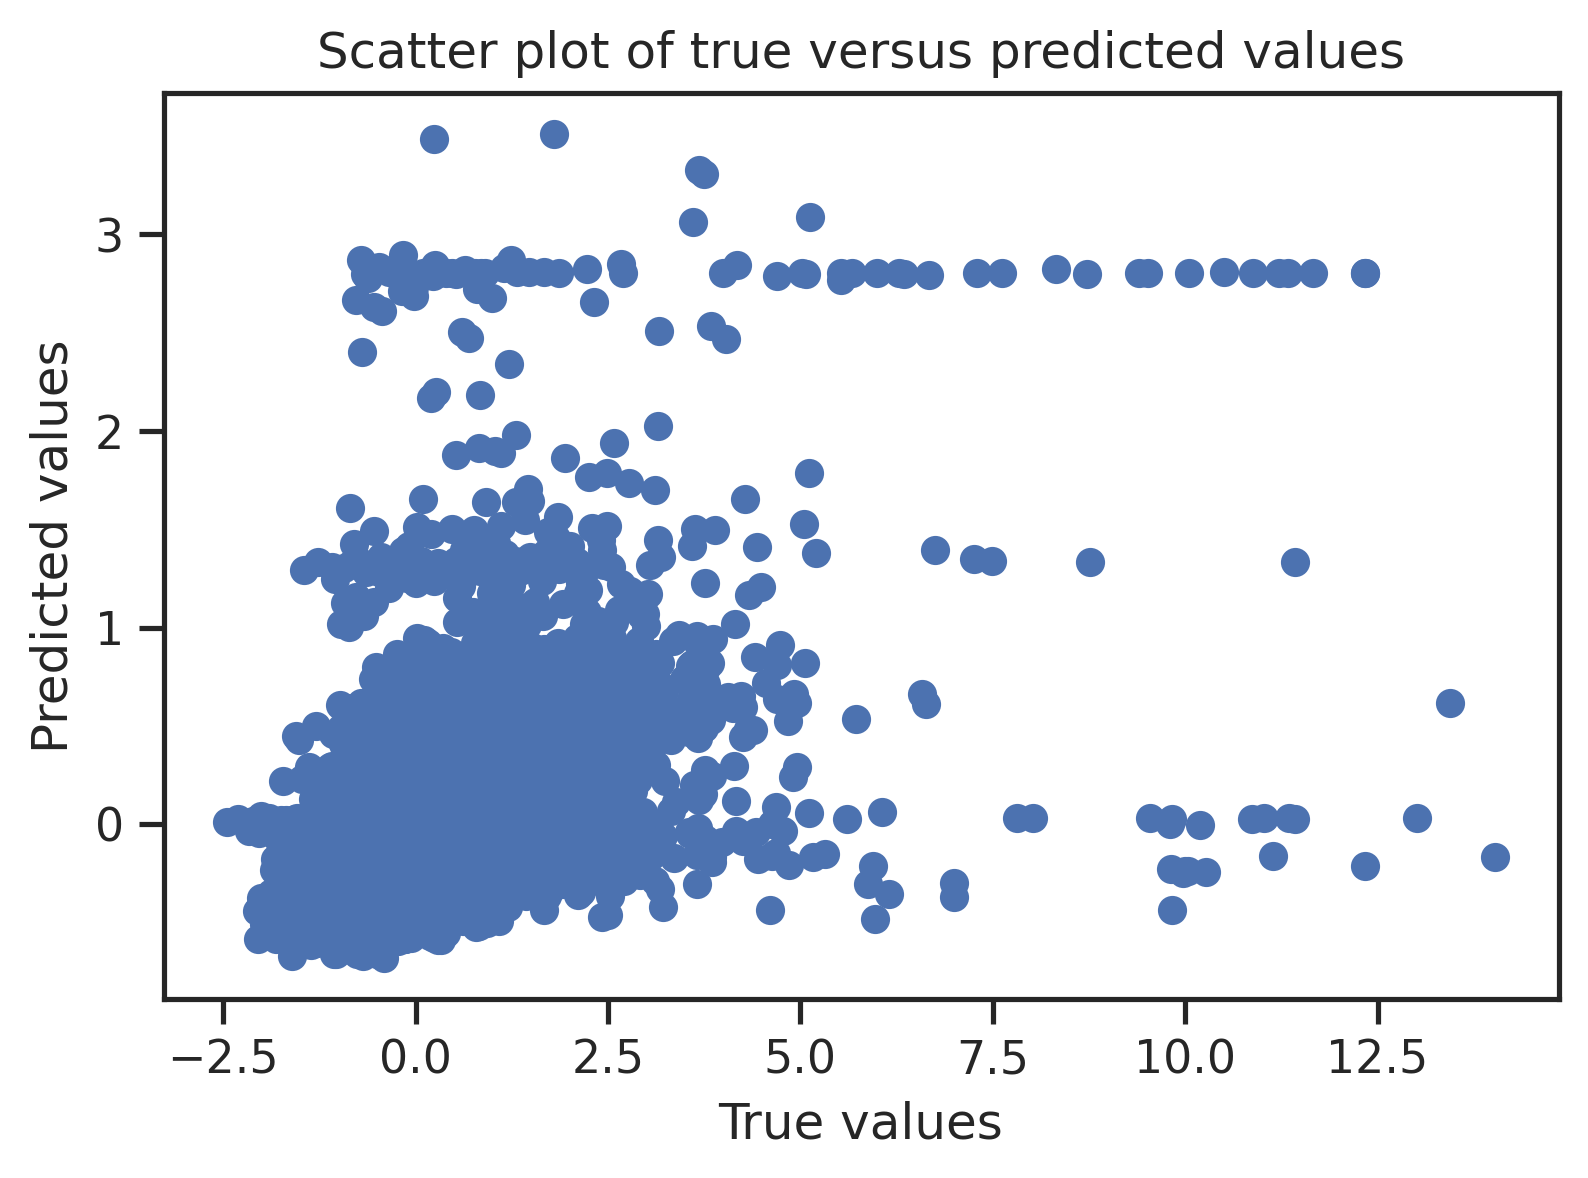

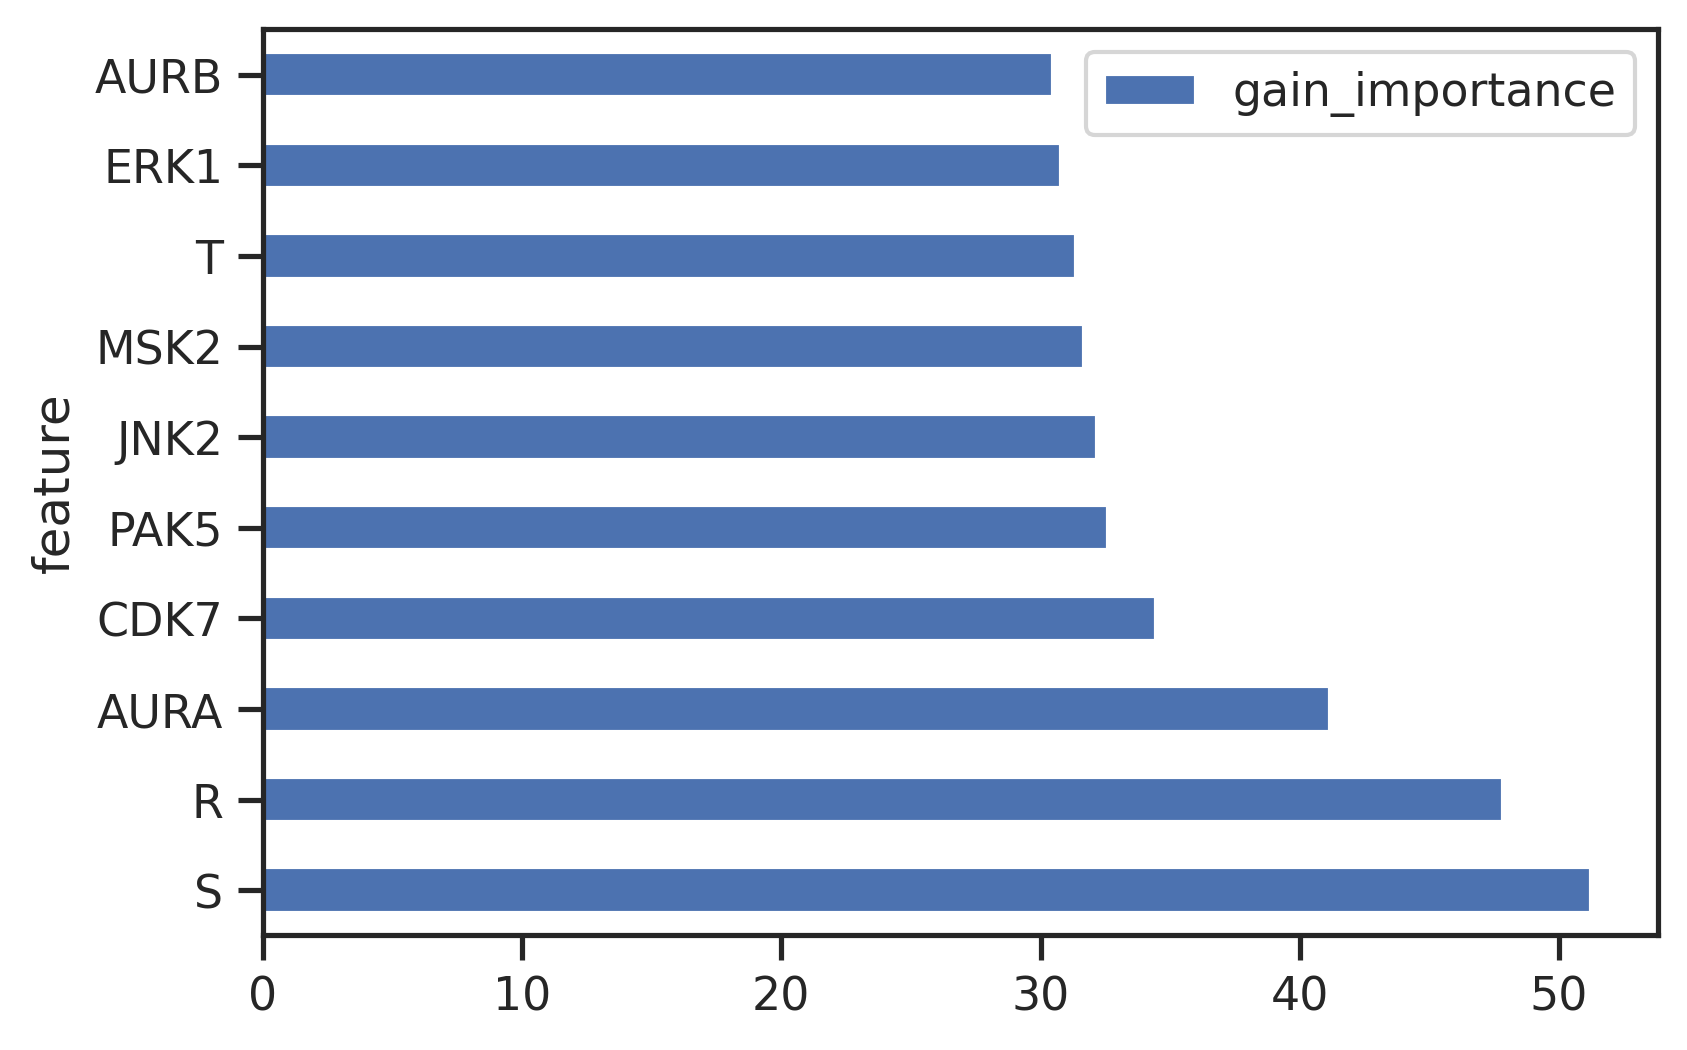

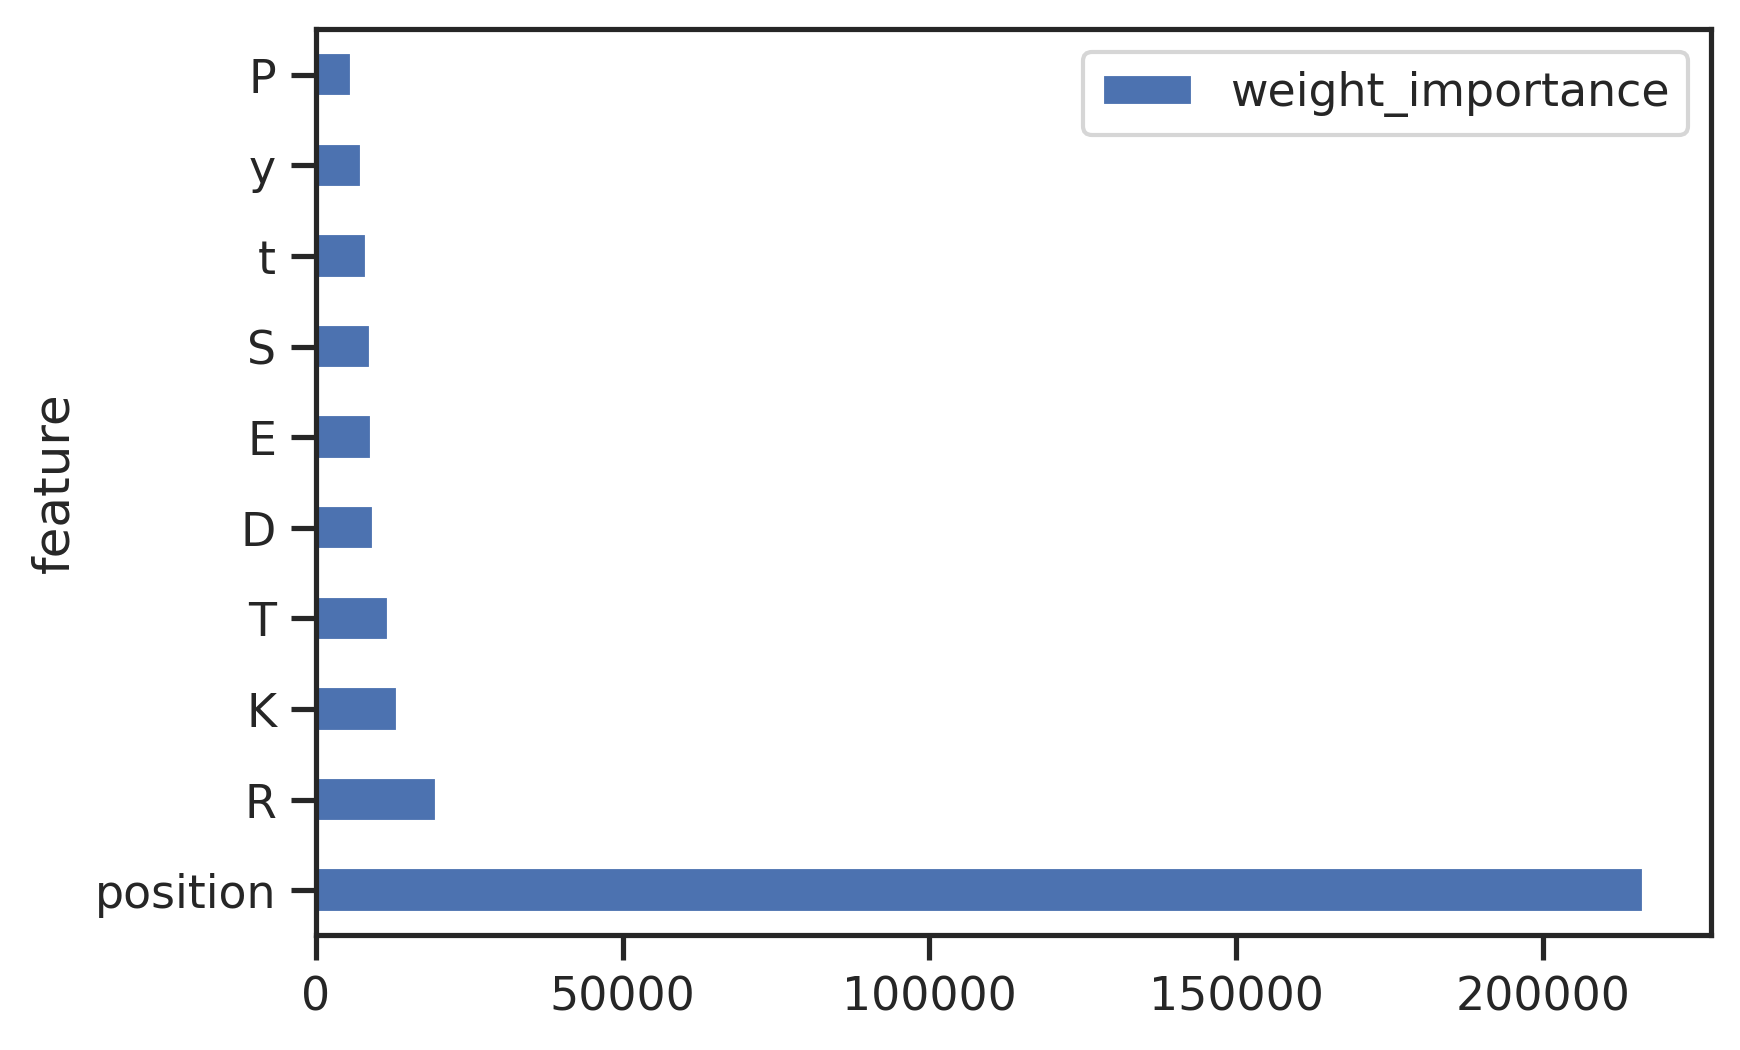

In [ ]:
pred, gain, weight = xgb_trainer(df, feat_col, target_col) #model_file = 'model/dummy.bin'

### StratifiedGroupKfold: split by group

We can use StratifiedGroupKFold to split the training and valid set: we group each point by kinase, and then stratify the kinase by their category. This split method ensures that the model:
- when validate in valid/test set, it would not see the same kinase in training set (no data leakage problem)
- during training, it learns diverse patterns of substrate specificity

In [ ]:
# prepare the dataframe for split
kinase_info = Data.get_kinase_info()

kinase_info = kinase_info[['kinase','Family','category','category_big']]

info = df[['kinase']].merge(kinase_info,'left')

We split data into 5 fold, with 80% train, and 20% valid. We can just train one fold; For statsitics purpose, we can train all five folds and get their variance and OOF (out of fold) to calculate overall correlation metrics.

# kinase in valid set: 61
# kinase in train set: 241
xgb params is: {'max_depth': 7, 'learning_rate': 0.001, 'subsample': 0.8, 'colsample_bytree': 1, 'eval_metric': 'rmse', 'objective': 'reg:squarederror', 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor', 'random_state': 123}
(47718, 325) (47718,) (12078, 325) (12078,)
Int64Index([    0,     5,    10,    15,    20,    25,    30,    36,    39,
               42,
            ...
            59748, 59755, 59758, 59763, 59769, 59775, 59779, 59782, 59790,
            59793],
           dtype='int64', length=12078)
[0]	train-rmse:16.28100	valid-rmse:16.50394
[100]	train-rmse:14.74073	valid-rmse:14.95880
[200]	train-rmse:13.34799	valid-rmse:13.56276
[300]	train-rmse:12.08888	valid-rmse:12.30113
[400]	train-rmse:10.95078	valid-rmse:11.16130
[500]	train-rmse:9.92223	valid-rmse:10.13261
[600]	train-rmse:8.99280	valid-rmse:9.20405
[700]	train-rmse:8.15324	valid-rmse:8.36570
[800]	train-rmse:7.39511	valid-rmse:7.60956
[900]	train-rmse:6.710

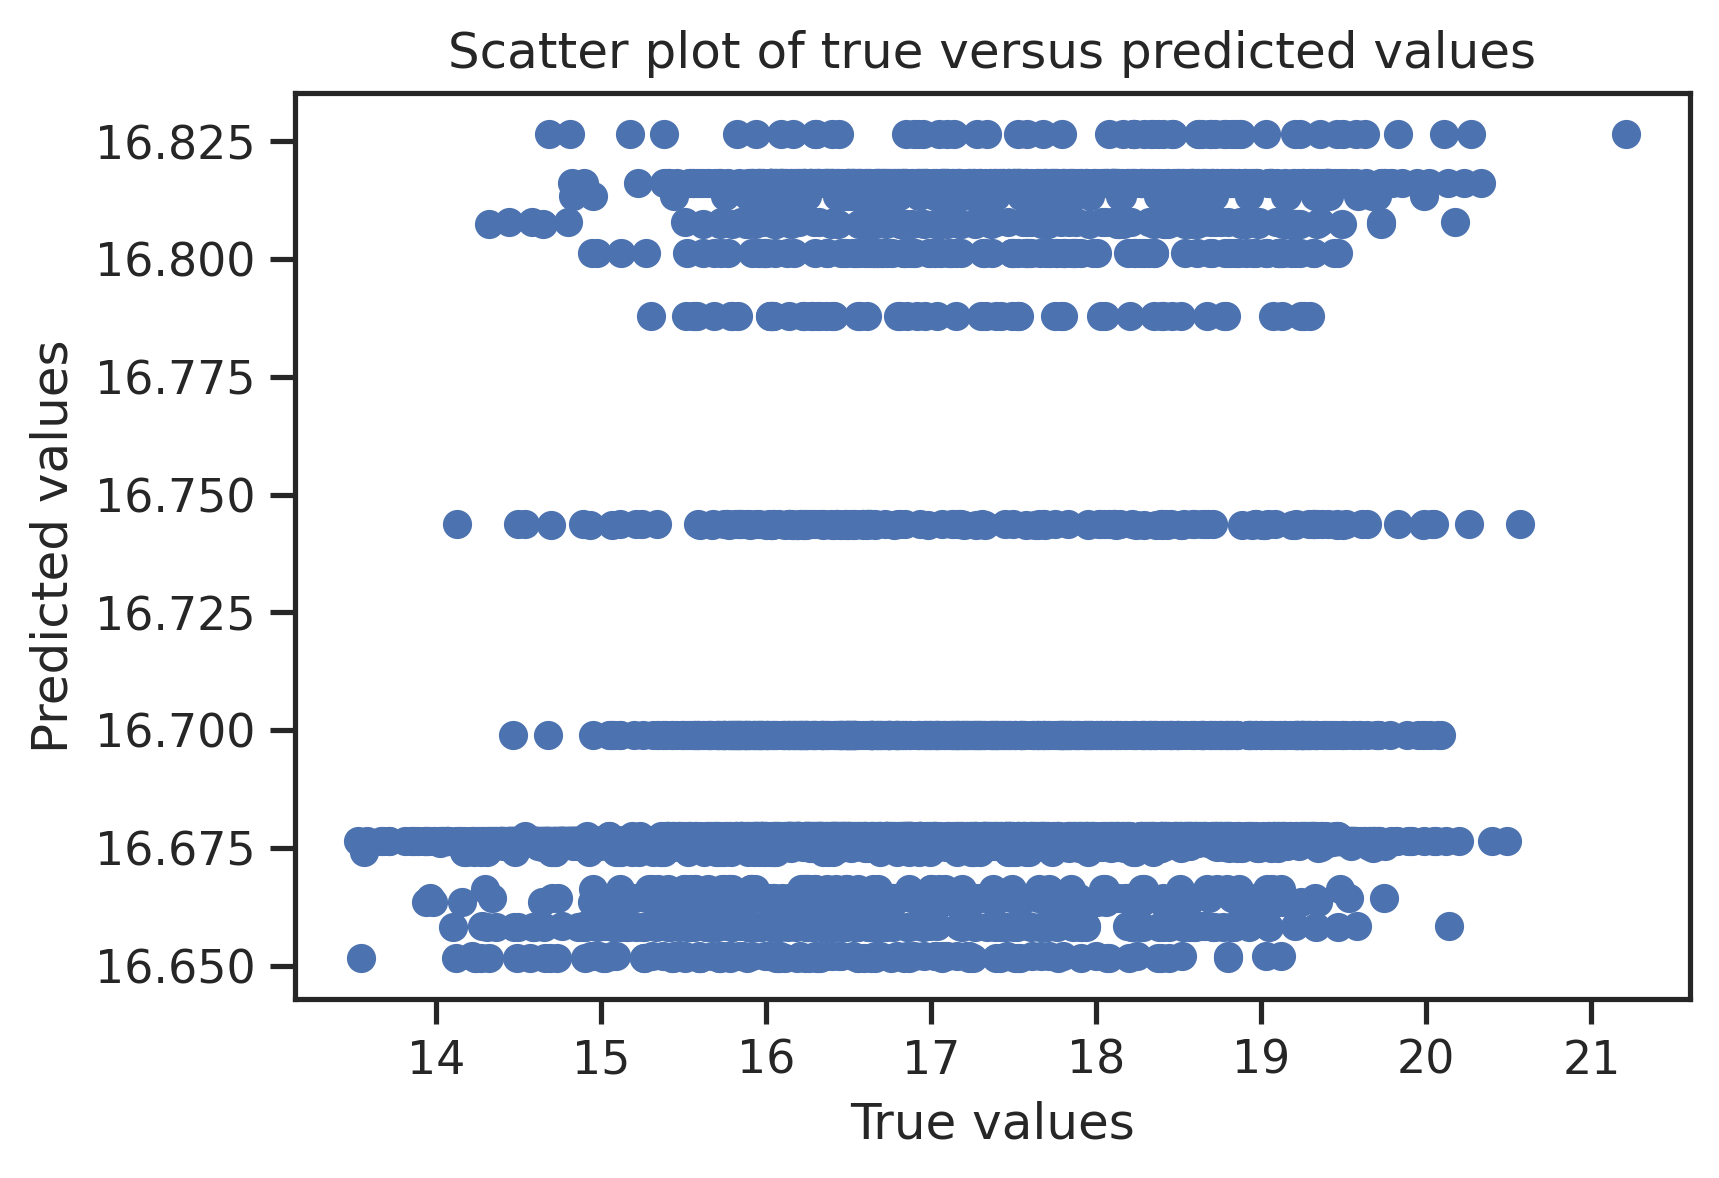

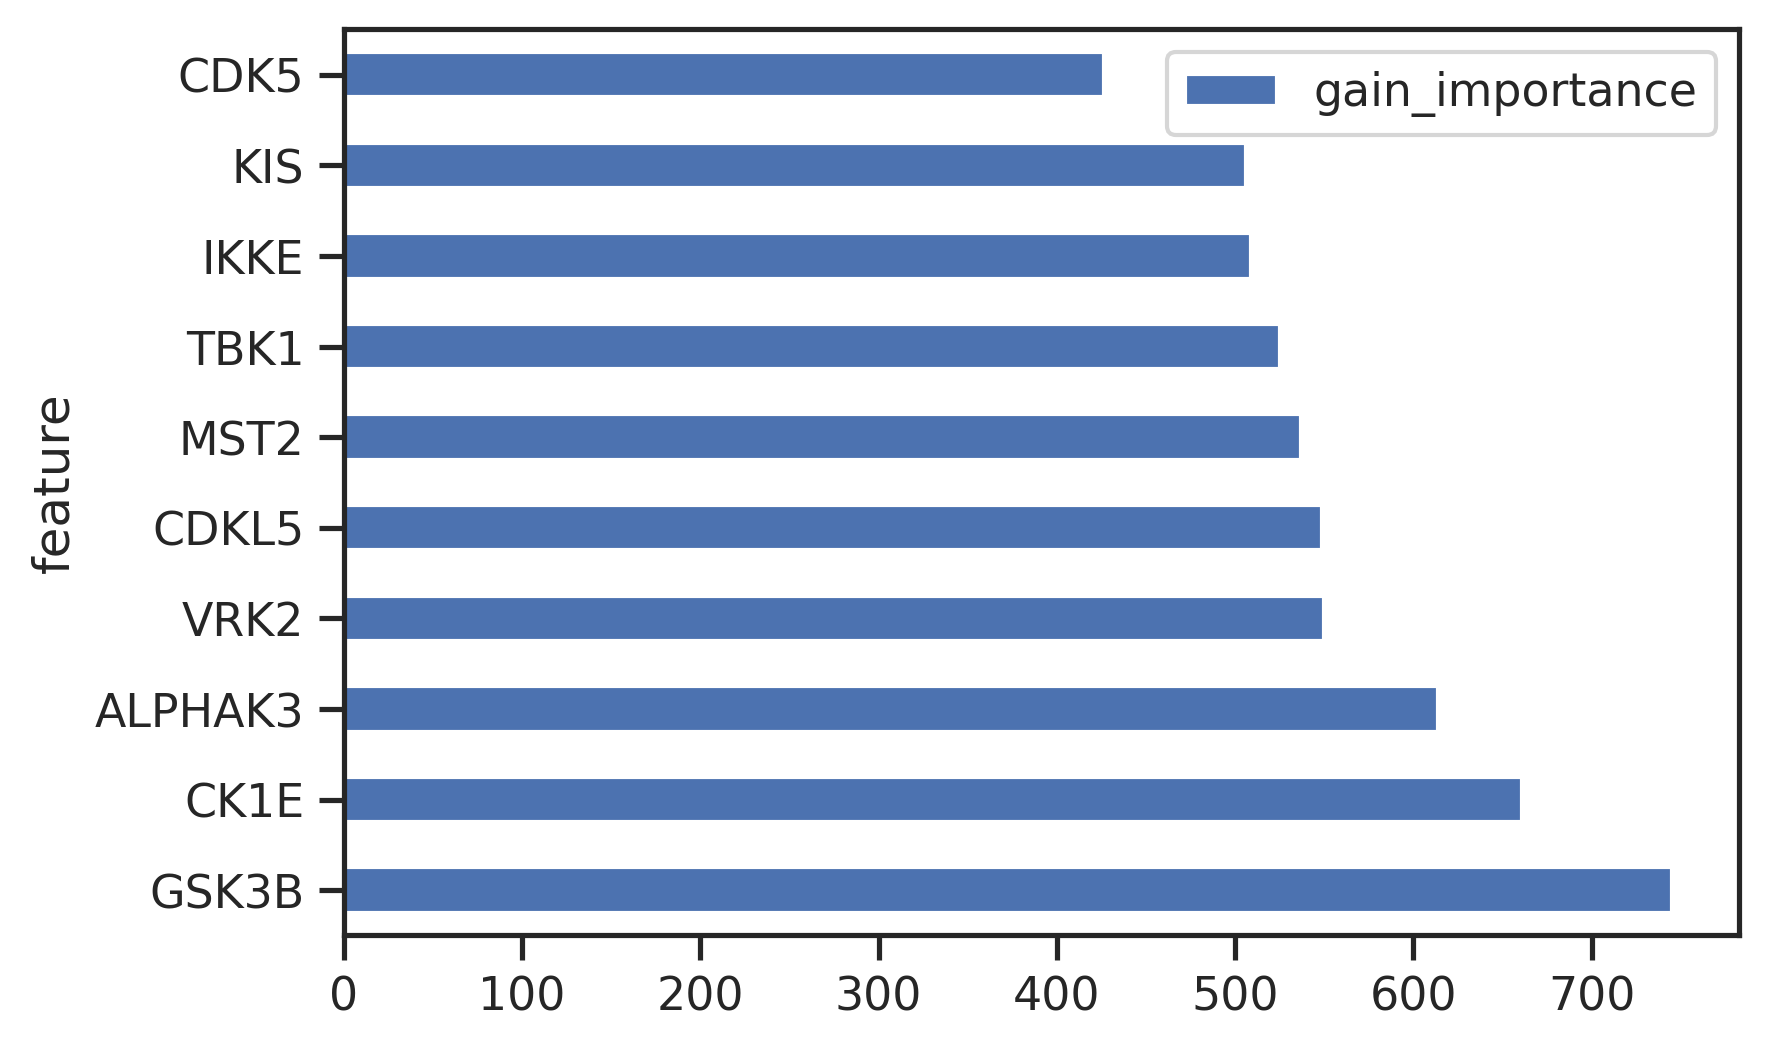

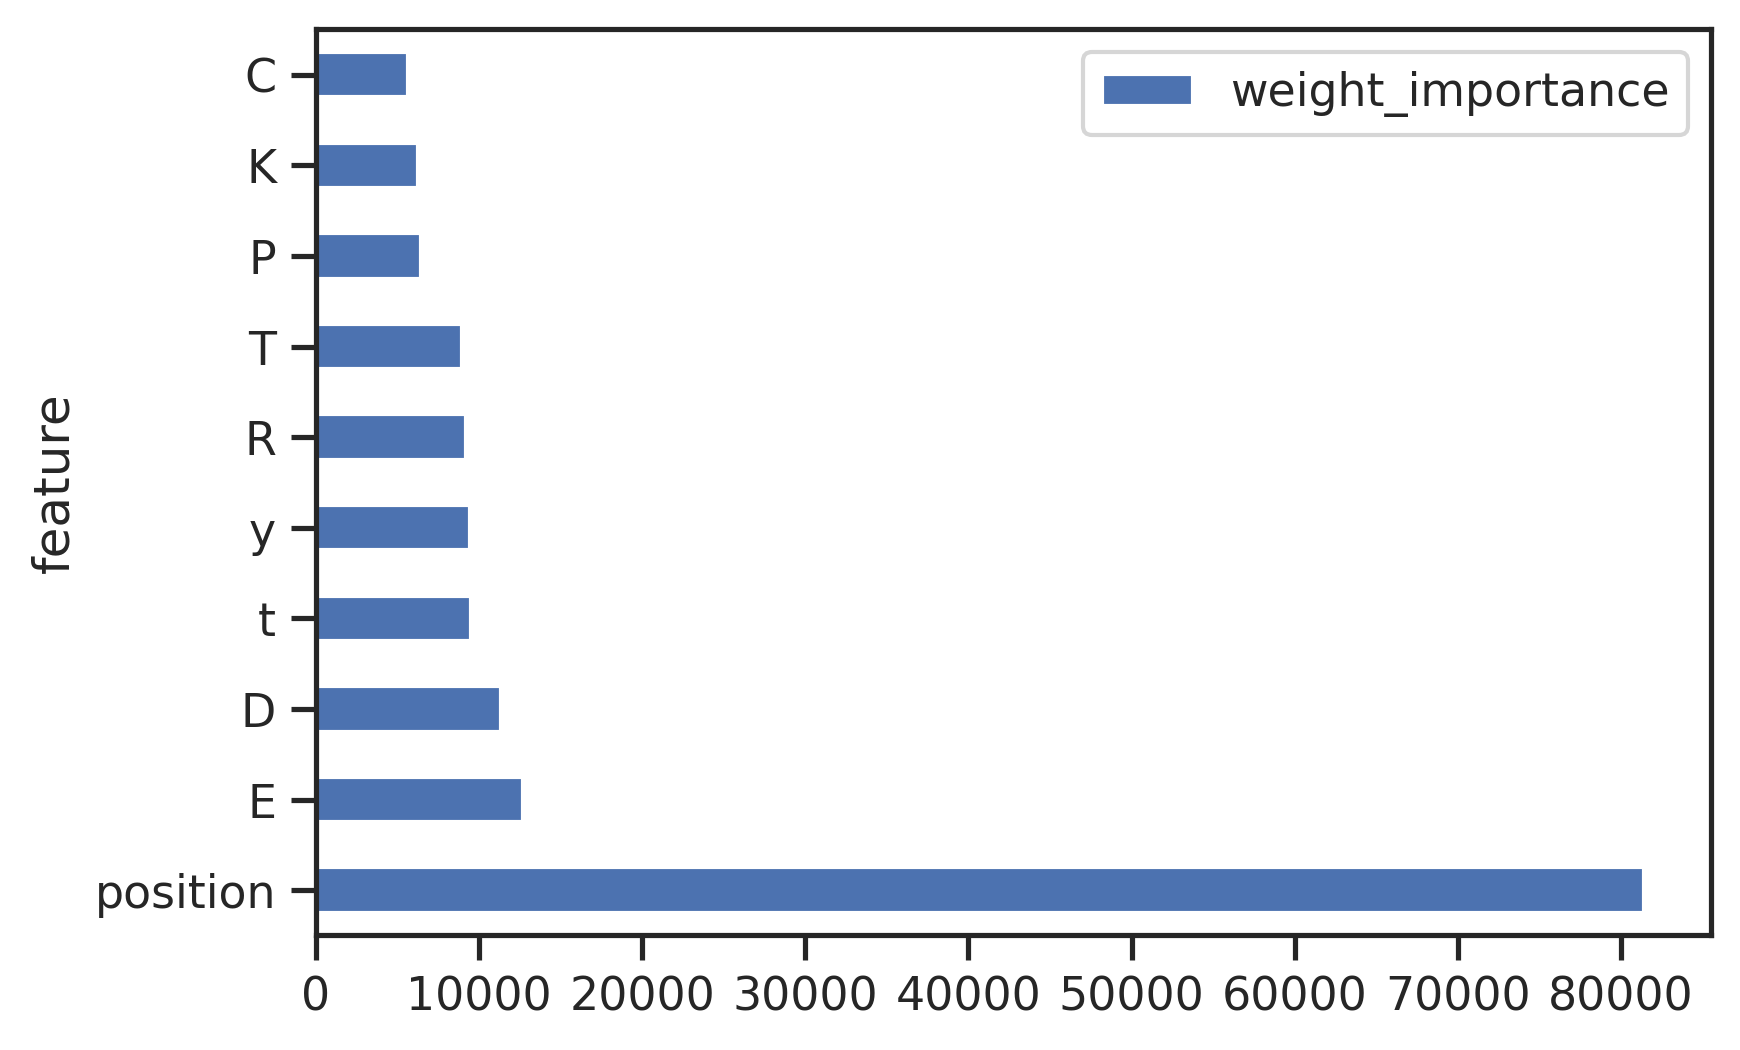

In [ ]:
FOLDS=5
pred_dfs = []
gains = []
weights = []
for fold, (train_idx, valid_idx) in enumerate(StratifiedGroupKFold(FOLDS).split(info.index.values, info.category,info.kinase)):
    print(f'# kinase in valid set: {info.loc[valid_idx].kinase.unique().shape[0]}')
    print(f'# kinase in train set: {info.loc[train_idx].kinase.unique().shape[0]}')
    pred_df, gain, weight = xgb_trainer(df, feat_col, target_col = 'target', test_index=valid_idx, model_file = f'model/fold{fold}.bin')
    pred_dfs.append(pred_df)
    gains.append(gain)
    weights.append(weight)
    break

## Save gain & weight importance

Save gain importance and weight importance of each fold to dataframes

In [ ]:
# gain importance
g = pd.concat(gains, axis=1, keys=range(len(gains)))

g.columns = ['gain_importance_'+ str(i) for i in range(FOLDS)]

In [ ]:
# weight importance
w = pd.concat(weights,axis=1,keys = range(len(weights)))

w.columns = ['weight_importance_'+ str(i) for i in range(FOLDS)]

In [ ]:
# g.to_csv('model/gains.csv')
# w.to_csv('model/weights.csv')

In [ ]:
g.head()

In [ ]:
w.head()

## Predict

Here's just an example. Suppose we prepared a test set

In [ ]:
show_doc(xgb_predict)

---

### xgb_predict

>      xgb_predict (df, feature_col, ID_col='ID', model_file='xgb_model.bin')

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| df |  |  | a dataframe that contains ID and features for prediction |
| feature_col |  |  | feature column name |
| ID_col | str | ID | ID column name |
| model_file | str | xgb_model.bin |  |

In [ ]:
test_idx = valid_idx

In [ ]:
test = df.loc[test_idx]

In [ ]:
test.head(2)

,kinase,substrate,target,position,aa,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y,t,y,AAK1,ACVR2A,ACVR2B,AKT1,AKT2,AKT3,ALK2,ALK4,ALPHAK3,AMPKA1,AMPKA2,ANKRD3,ASK1,ATM,ATR,AURA,AURB,AURC,BCKDK,BIKE,BMPR1A,BMPR1B,BMPR2,BRAF,BRSK1,BRSK2,BUB1,CAMK1A,CAMK1B,CAMK1D,CAMK1G,CAMK2A,CAMK2B,CAMK2D,CAMK2G,CAMK4,CAMKK1,CAMKK2,CAMLCK,CDC7,CDK1,CDK10,CDK12,CDK13,CDK14,CDK16,CDK17,CDK18,CDK19,CDK2,CDK3,CDK4,CDK5,CDK6,CDK7,CDK8,CDK9,CDKL1,CDKL5,CHAK1,CHAK2,CHK1,CHK2,CK1A,CK1A2,CK1D,CK1E,CK1G1,CK1G3,CK2A1,CK2A2,CLK1,CLK2,CLK3,CLK4,COT,CRIK,DAPK1,DAPK2,DAPK3,DCAMKL1,DCAMKL2,DLK,DMPK1,DNAPK,DRAK1,DSTYK,DYRK1A,DYRK1B,DYRK2,DYRK3,DYRK4,EEF2K,ERK1,ERK2,ERK5,ERK7,FAM20C,GAK,GCK,GCN2,GRK1,GRK2,GRK3,GRK4,GRK5,GRK6,GRK7,GSK3A,GSK3B,HASPIN,HGK,HIPK1,HIPK2,HIPK3,HIPK4,HPK1,HRI,HUNK,ICK,IKKA,IKKB,IKKE,IRAK1,IRAK4,IRE1,IRE2,JNK1,JNK2,JNK3,KHS1,KHS2,KIS,LATS1,LATS2,LKB1,LOK,LRRK2,MAK,MAP3K15,MAPKAPK2,MAPKAPK3,MAPKAPK5,MARK1,MARK2,MARK3,MARK4,MASTL,MEK1,MEK2,MEK5,MEKK1,MEKK2,MEKK3,MEKK6,MELK,MINK,MLK1,MLK2,MLK3,MLK4,MNK1,MNK2,MOK,MOS,MPSK1,MRCKA,MRCKB,MSK1,MSK2,MST1,MST2,MST3,MST4,MTOR,MYLK4,MYO3A,MYO3B,NDR1,NDR2,NEK1,NEK11,NEK2,NEK3,NEK4,NEK5,NEK6,NEK7,NEK8,NEK9,NIK,NIM1,NLK,NUAK1,NUAK2,OSR1,P38A,P38B,P38D,P38G,P70S6K,P70S6KB,P90RSK,PAK1,PAK2,PAK3,PAK4,PAK5,PAK6,PASK,PBK,PDHK1,PDHK4,PDK1,PERK,PHKG1,PHKG2,PIM1,PIM2,PIM3,PINK1,PKACA,PKACB,PKACG,PKCA,PKCB,PKCD,PKCE,PKCG,PKCH,PKCI,PKCT,PKCZ,PKG1,PKG2,PKN1,PKN2,PKN3,PKR,PLK1,PLK2,PLK3,PLK4,PRKD1,PRKD2,PRKD3,PRKX,PRP4,PRPK,QIK,QSK,RAF1,RIPK1,RIPK2,RIPK3,ROCK1,ROCK2,RSK2,RSK3,RSK4,SBK,SGK1,SGK3,SIK,SKMLCK,SLK,SMG1,SMMLCK,SNRK,SRPK1,SRPK2,SRPK3,SSTK,STK33,STLK3,TAK1,TAO1,TAO2,TAO3,TBK1,TGFBR1,TGFBR2,TLK1,TLK2,TNIK,TSSK1,TSSK2,TTBK1,TTBK2,TTK,ULK1,ULK2,VRK1,VRK2,WNK1,WNK3,WNK4,YANK2,YANK3,YSK1,YSK4,ZAK
0,AAK1,-5P,15.845517,-5,P,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,AKT3,-5P,15.962520,-5,P,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
pred_test = xgb_predict(test, feat_col, ID_col = 'kinase', model_file = 'model/fold0.bin')

Check whether predict works

In [ ]:
(pred_test.preds.round(2) == pred_df.pred.round(2)).value_counts()

True    12078
dtype: int64

## Transform target/pred back

In [ ]:
pred_df.head()

,label,pred
0,15.845517,16.676548
5,15.962520,16.676548
10,17.624320,16.676548
15,15.553056,16.676548
20,14.881759,16.676548


As we log transform the label, we need to transform them back

In [ ]:
pred_df = pred_df.apply(np.exp)

Combine all info

In [ ]:
pred = pd.concat([pred_df, df[['kinase','substrate','position','aa']].loc[pred_df.index],info.loc[pred_df.index].drop(columns='kinase')], axis=1)

In [ ]:
pred.kinase.unique().shape

(61,)

In [ ]:
pred.head()

,label,pred,kinase,substrate,position,aa,Family,category,category_big
0,7614135.38,17479652.0,AAK1,-5P,-5,P,Other,NAK,NAK
5,8559224.07,17479652.0,AKT3,-5P,-5,P,AGC,AKT/ROCK,basophilic
10,45096734.42,17479652.0,AMPKA2,-5P,-5,P,CAMK,AMPK,basophilic
15,5683378.86,17479652.0,AURA,-5P,-5,P,Other,AURK/PKA,basophilic
20,2904463.06,17479652.0,BMPR1A,-5P,-5,P,TKL,TGFBR,acidophilic


## Overall analysis

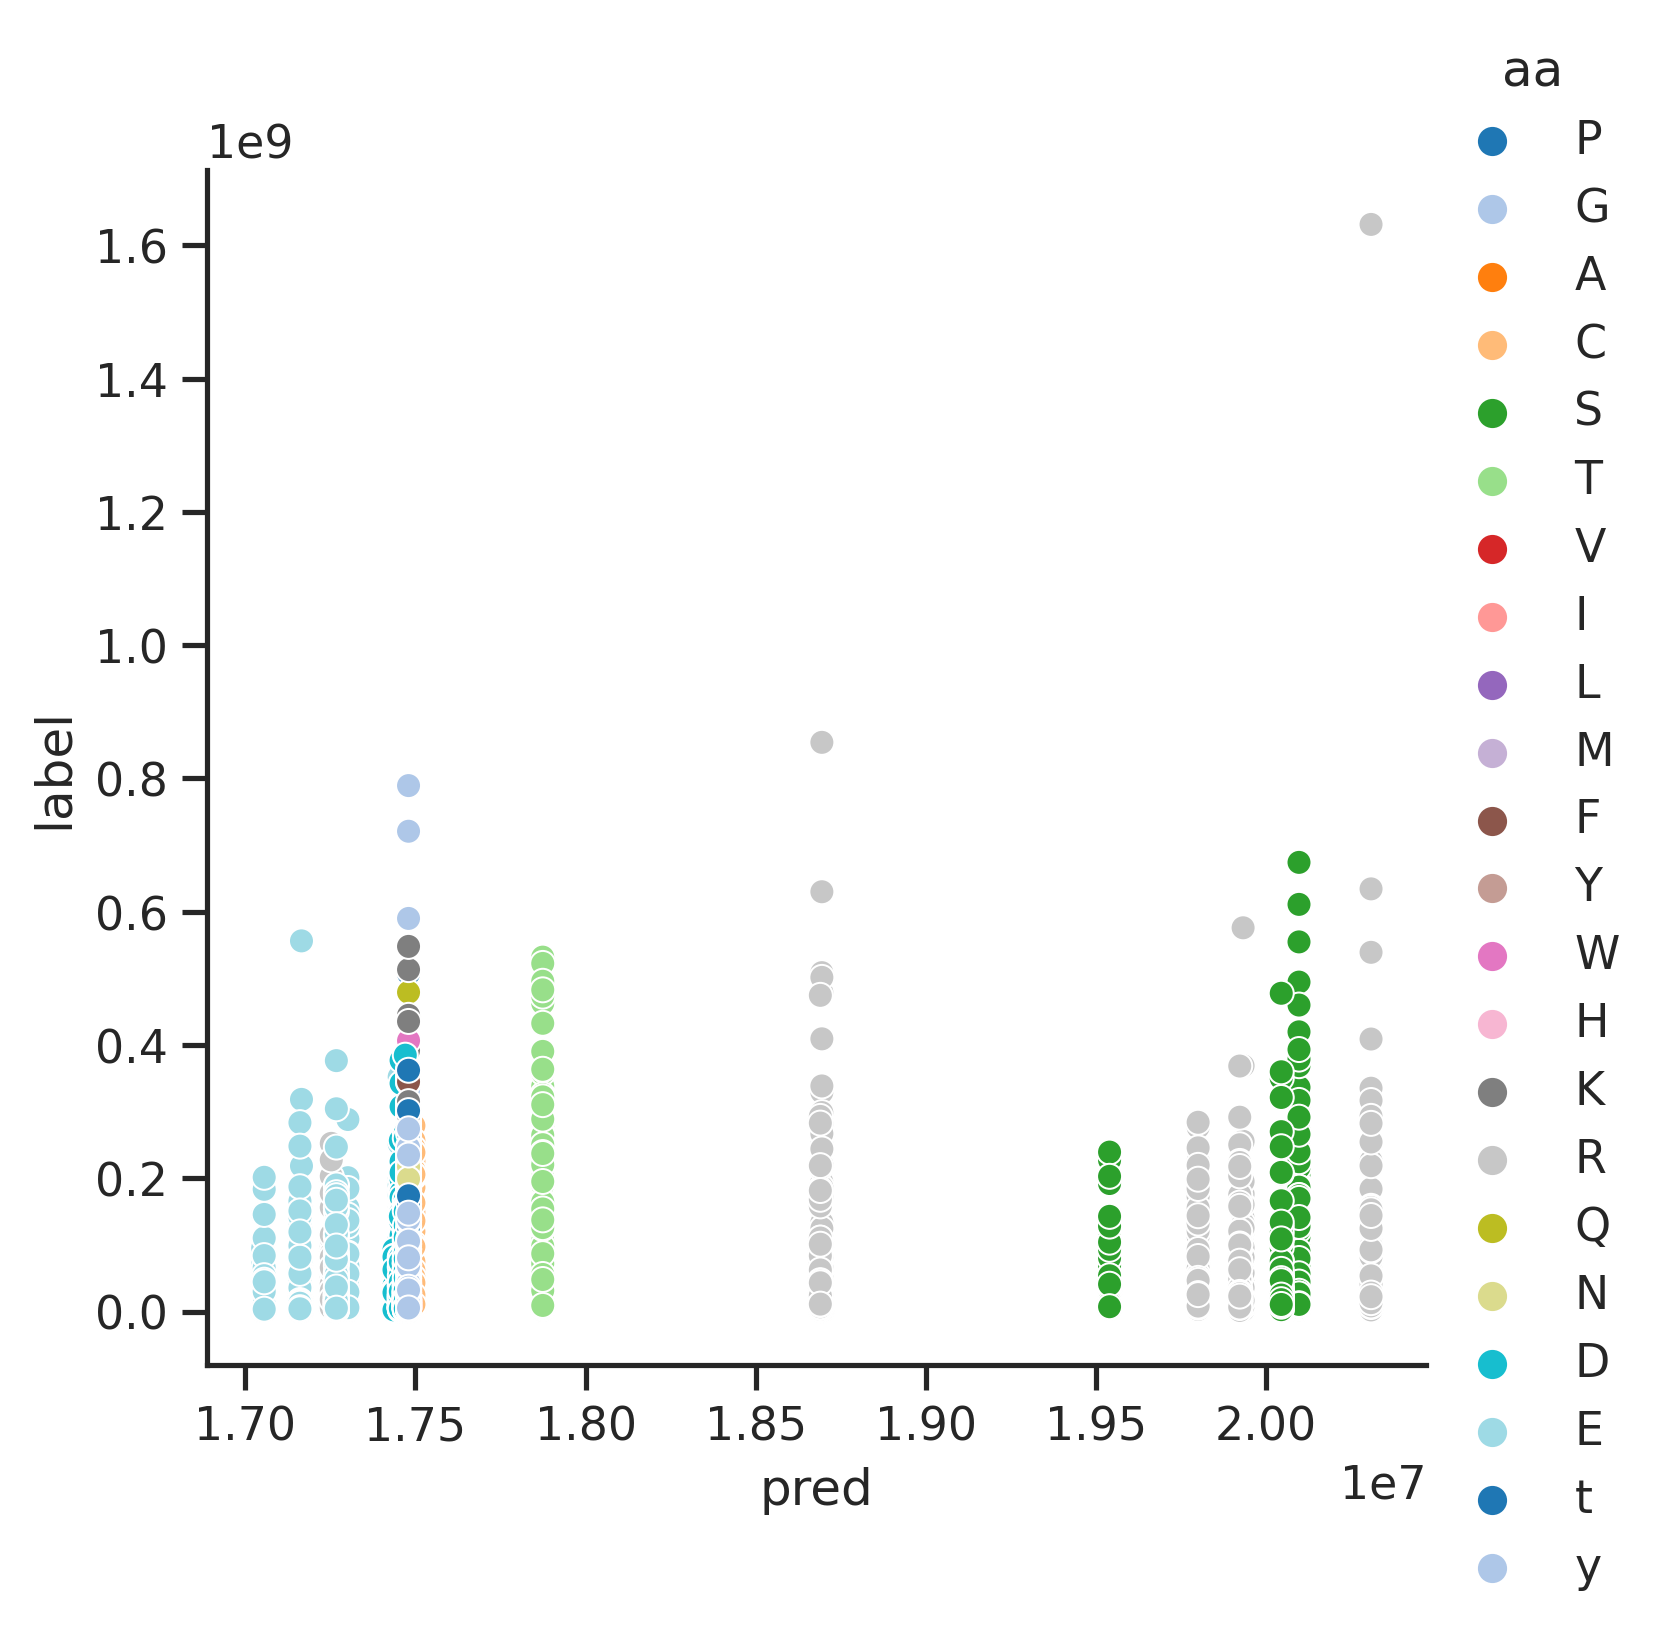

In [ ]:
sns.relplot(x=pred.pred, y=pred.label, hue = pred.aa,palette='tab20');

Check which substrate (position+aa) is favored by the model

In [ ]:
pred.groupby('substrate').pred.mean().sort_values(ascending=False)

substrate
-3R    20309574.0
-5S    20097748.0
-1S    20097748.0
-3S    20097748.0
2S     20097748.0
          ...    
-3E    17164860.0
-1E    17160308.0
-2E    17160308.0
2E     17055270.0
1E     17050750.0
Name: pred, Length: 198, dtype: float32

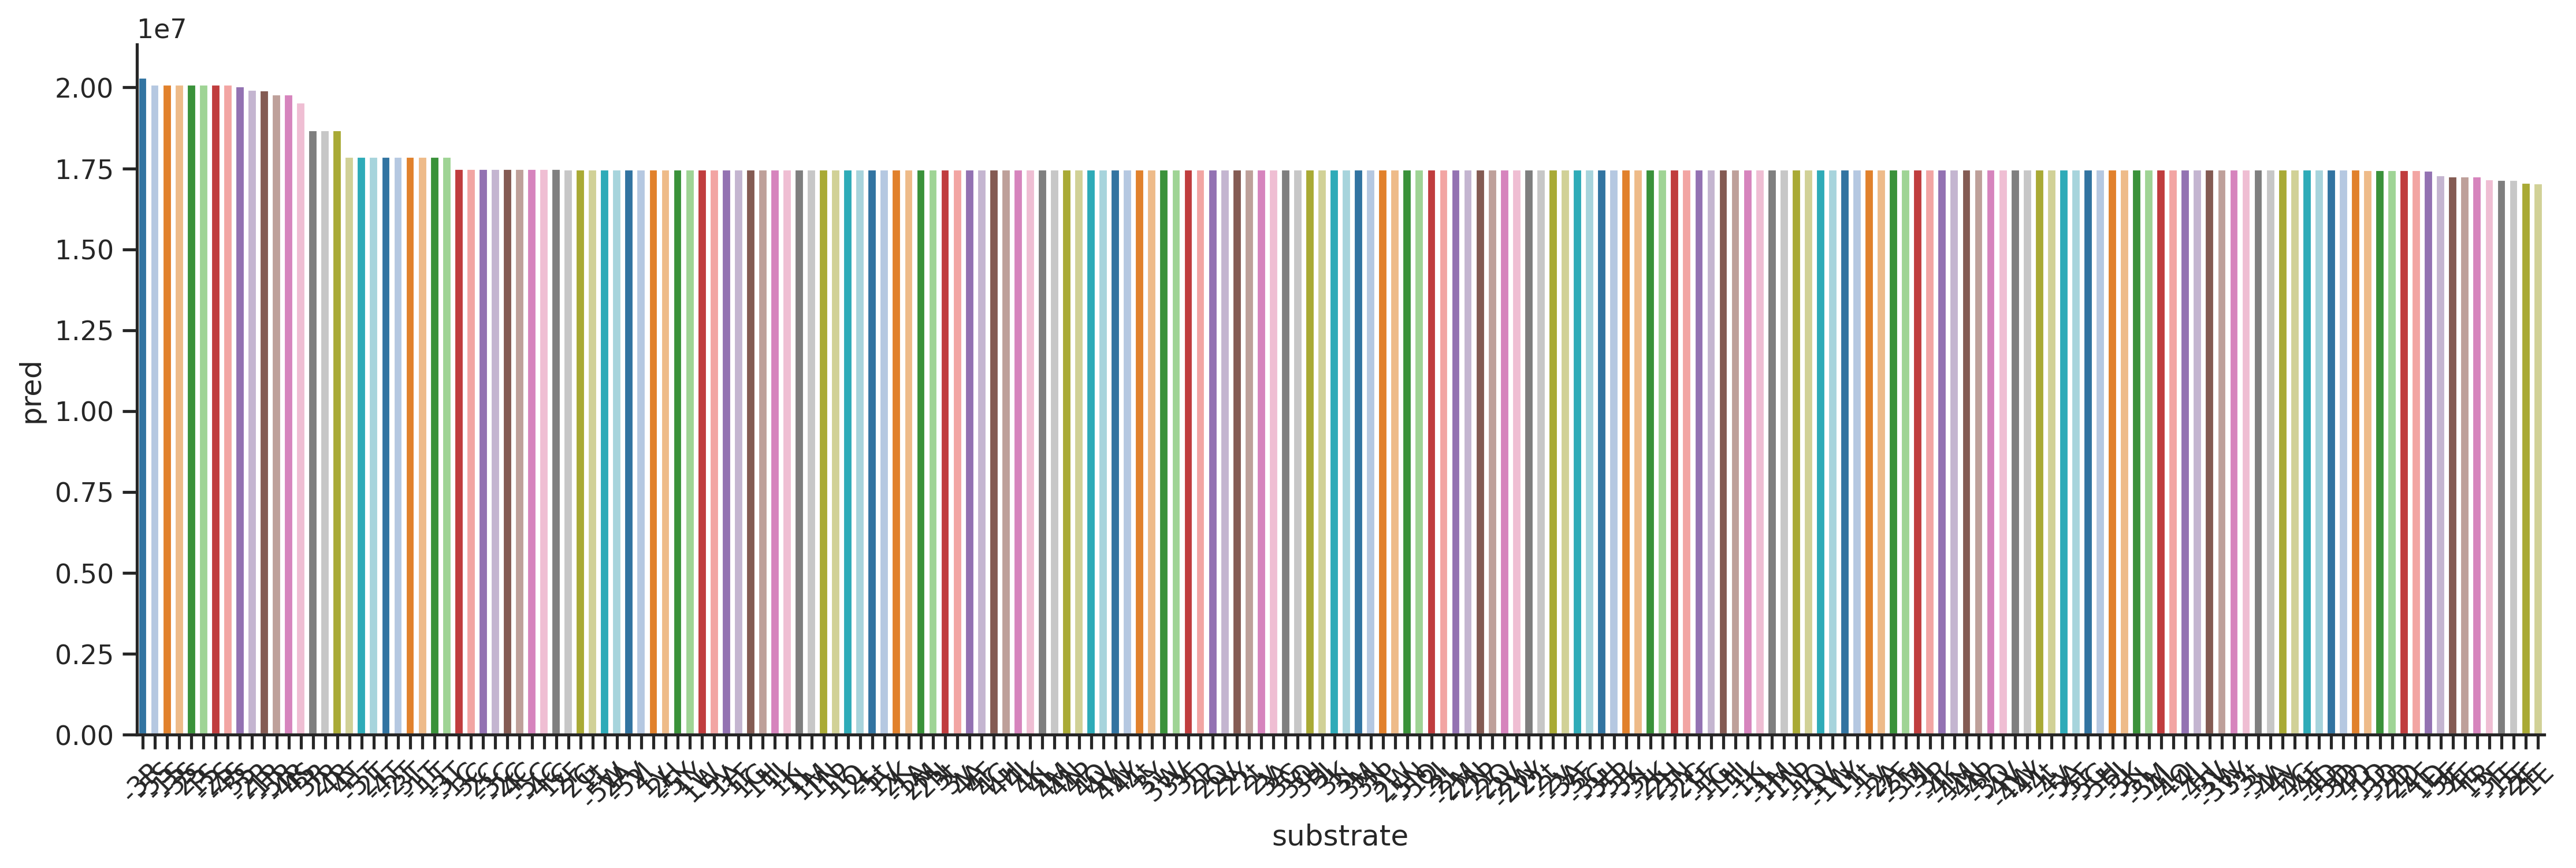

In [ ]:
plot_bar(pred, 'pred','substrate', circle = False)

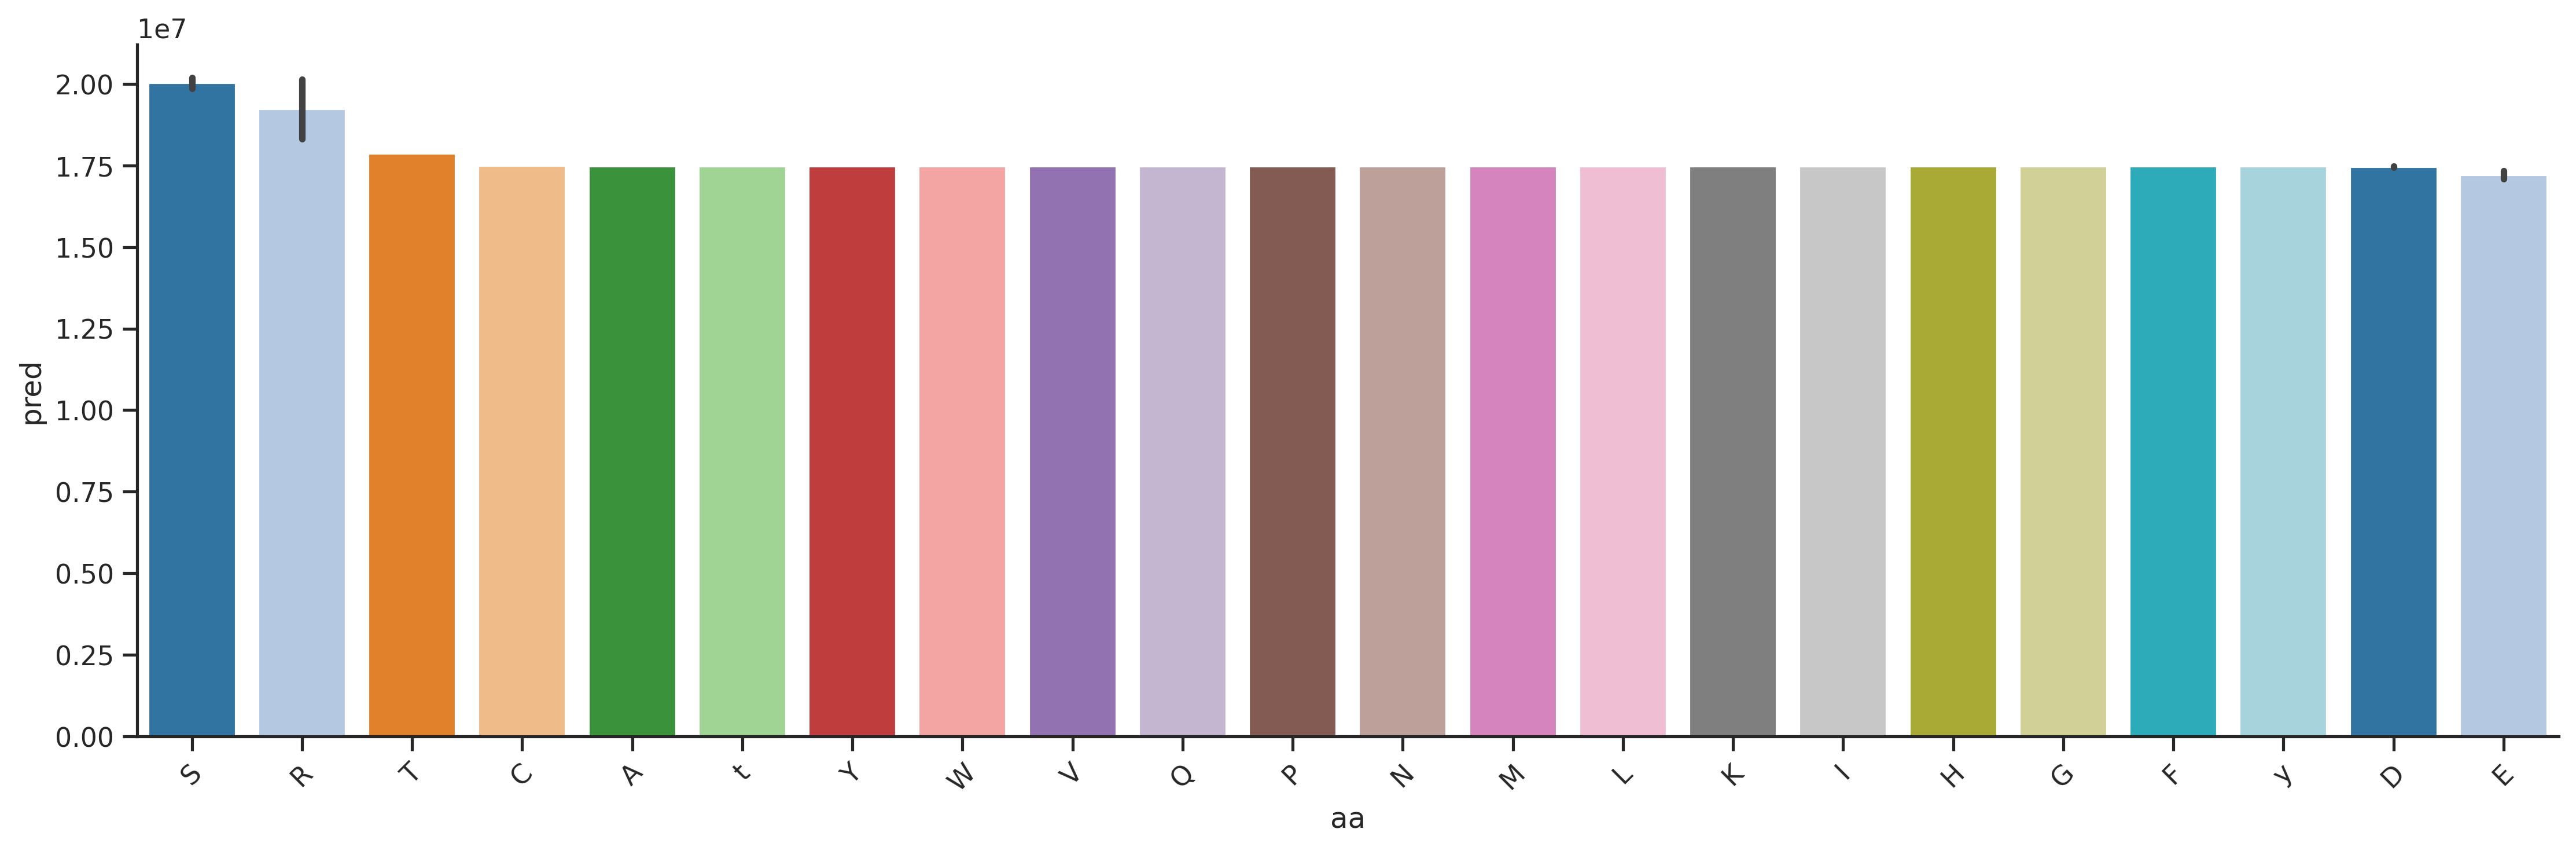

In [ ]:
plot_bar(pred, 'pred','aa', circle = False)

## Analysis - Individual kinase check

In [ ]:
from katlas.plot import *

In [ ]:
raw_stack = Data.get_kinase_raw()

# Notice here we use np.exp to convert the log back, if the target is processed in other ways, use other method
pred_stack = pred.pivot(values = 'pred',index='kinase',columns = 'substrate').reset_index()

label_stack = pred.pivot(values = 'label',index='kinase',columns = 'substrate').reset_index()

### Check original logo

In [ ]:
k = "PAK3"

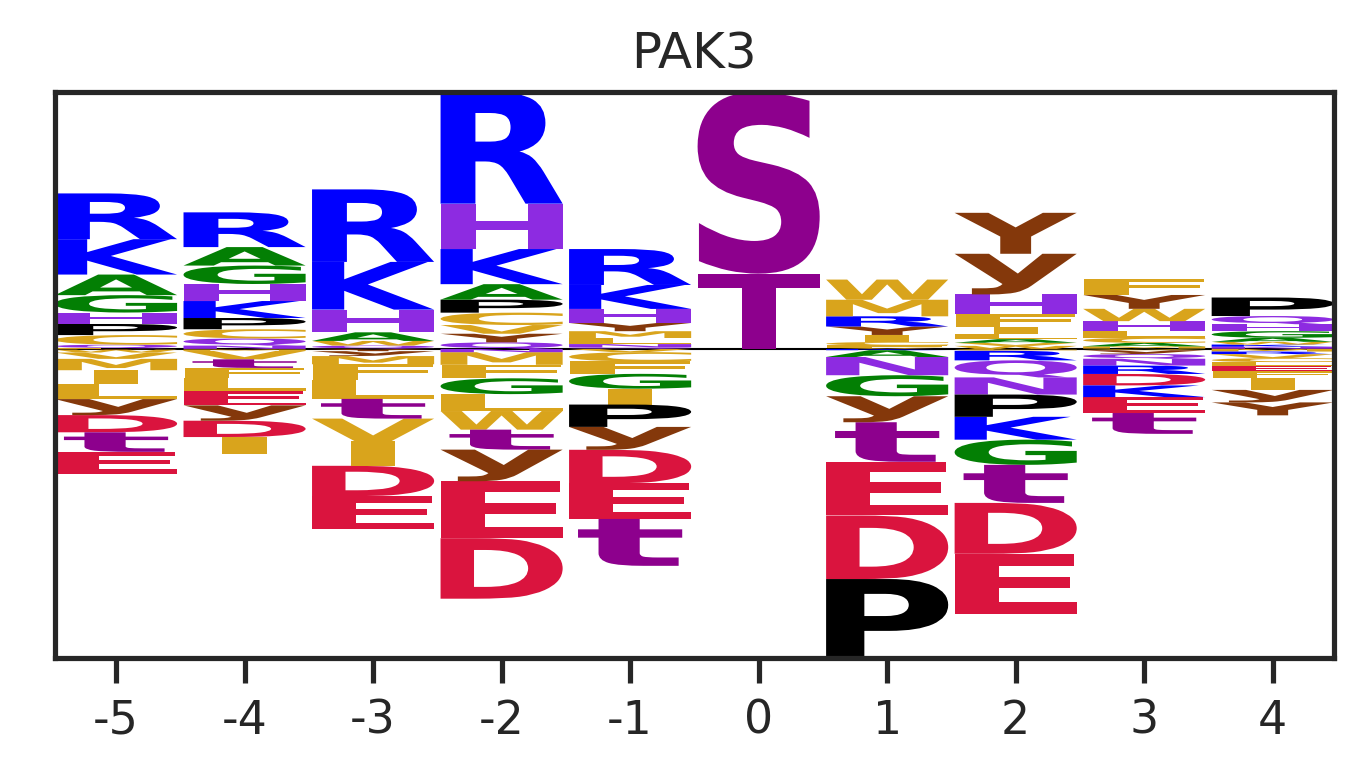

In [ ]:
raw2logo(raw_stack, k)

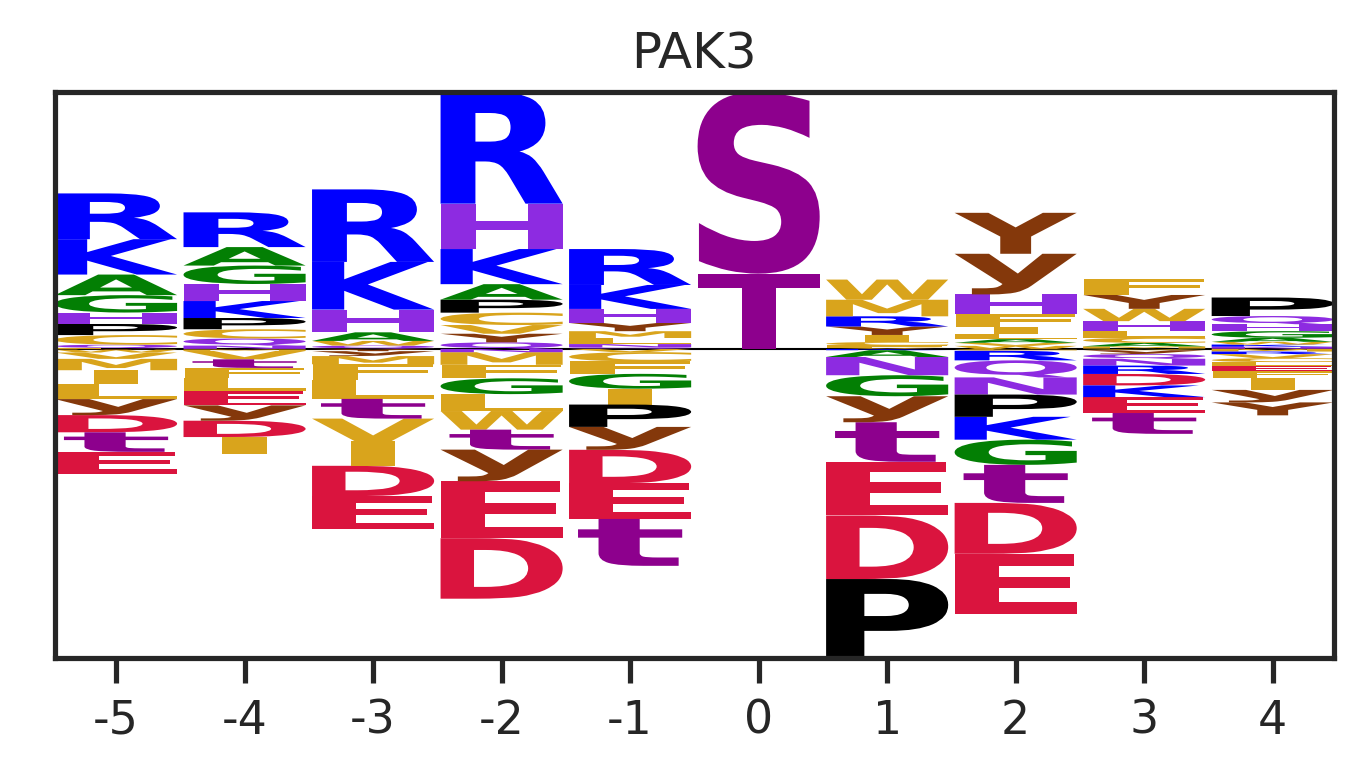

In [ ]:
raw2logo(label_stack, k)

Looks same with the original after np.exp back

### Check predicted logo

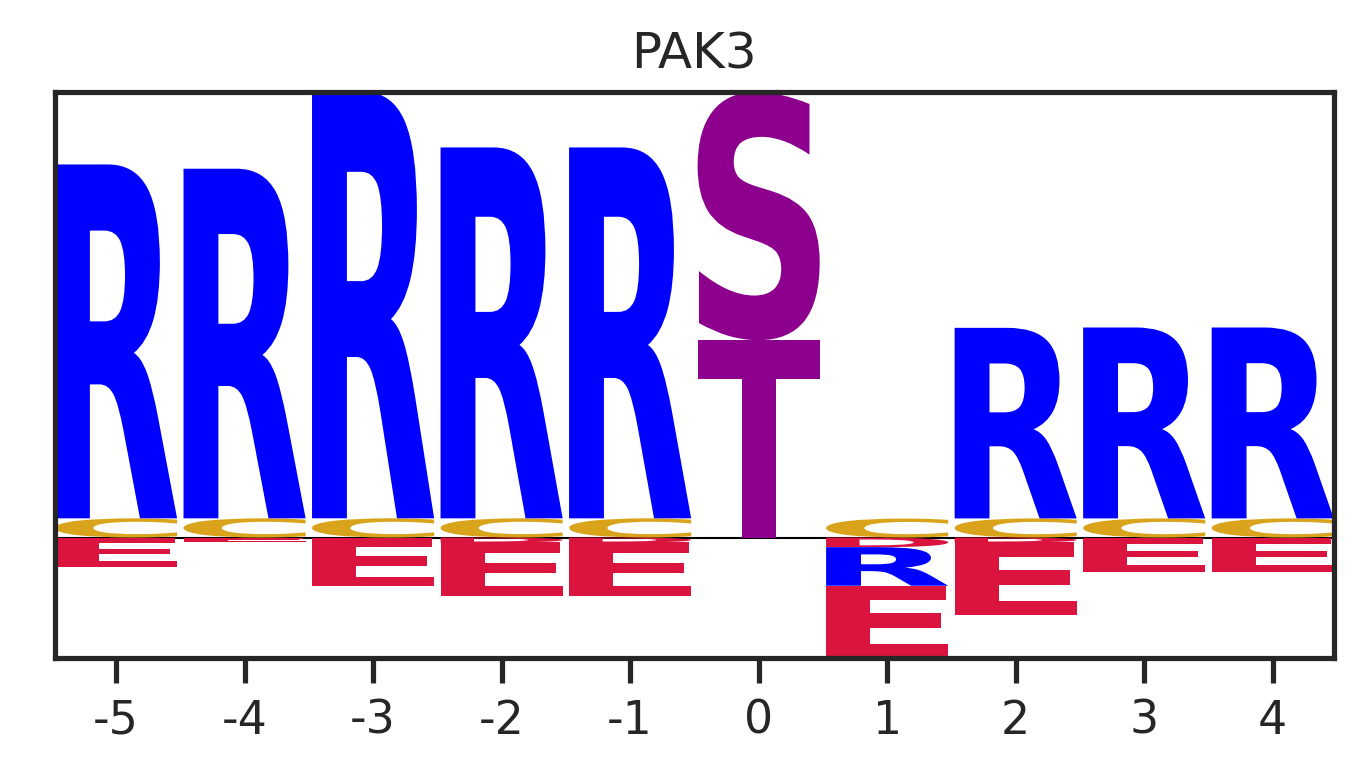

In [ ]:
raw2logo(pred_stack, k)

### Plot correlation

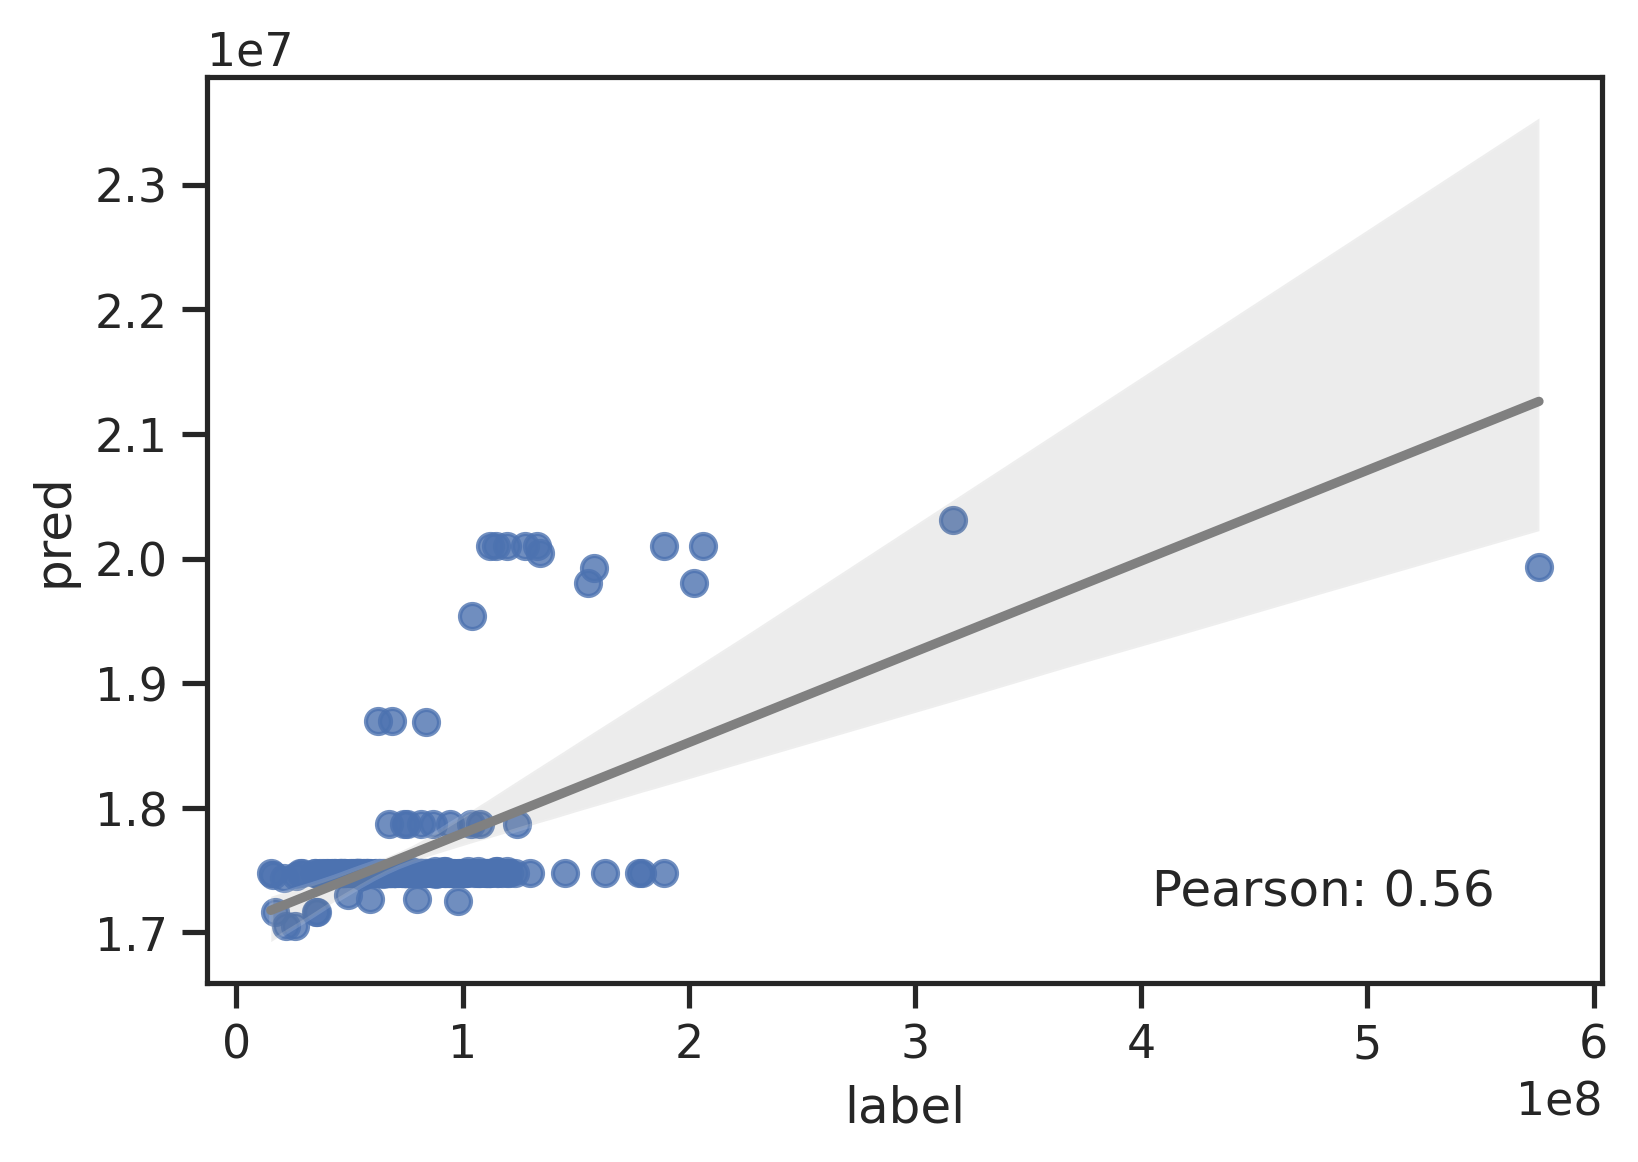

In [ ]:
plot_corr(pred.query(f'kinase == "{k}"').label,
          pred.query(f'kinase == "{k}"').pred, 
          method='pearson')

Colored by aa

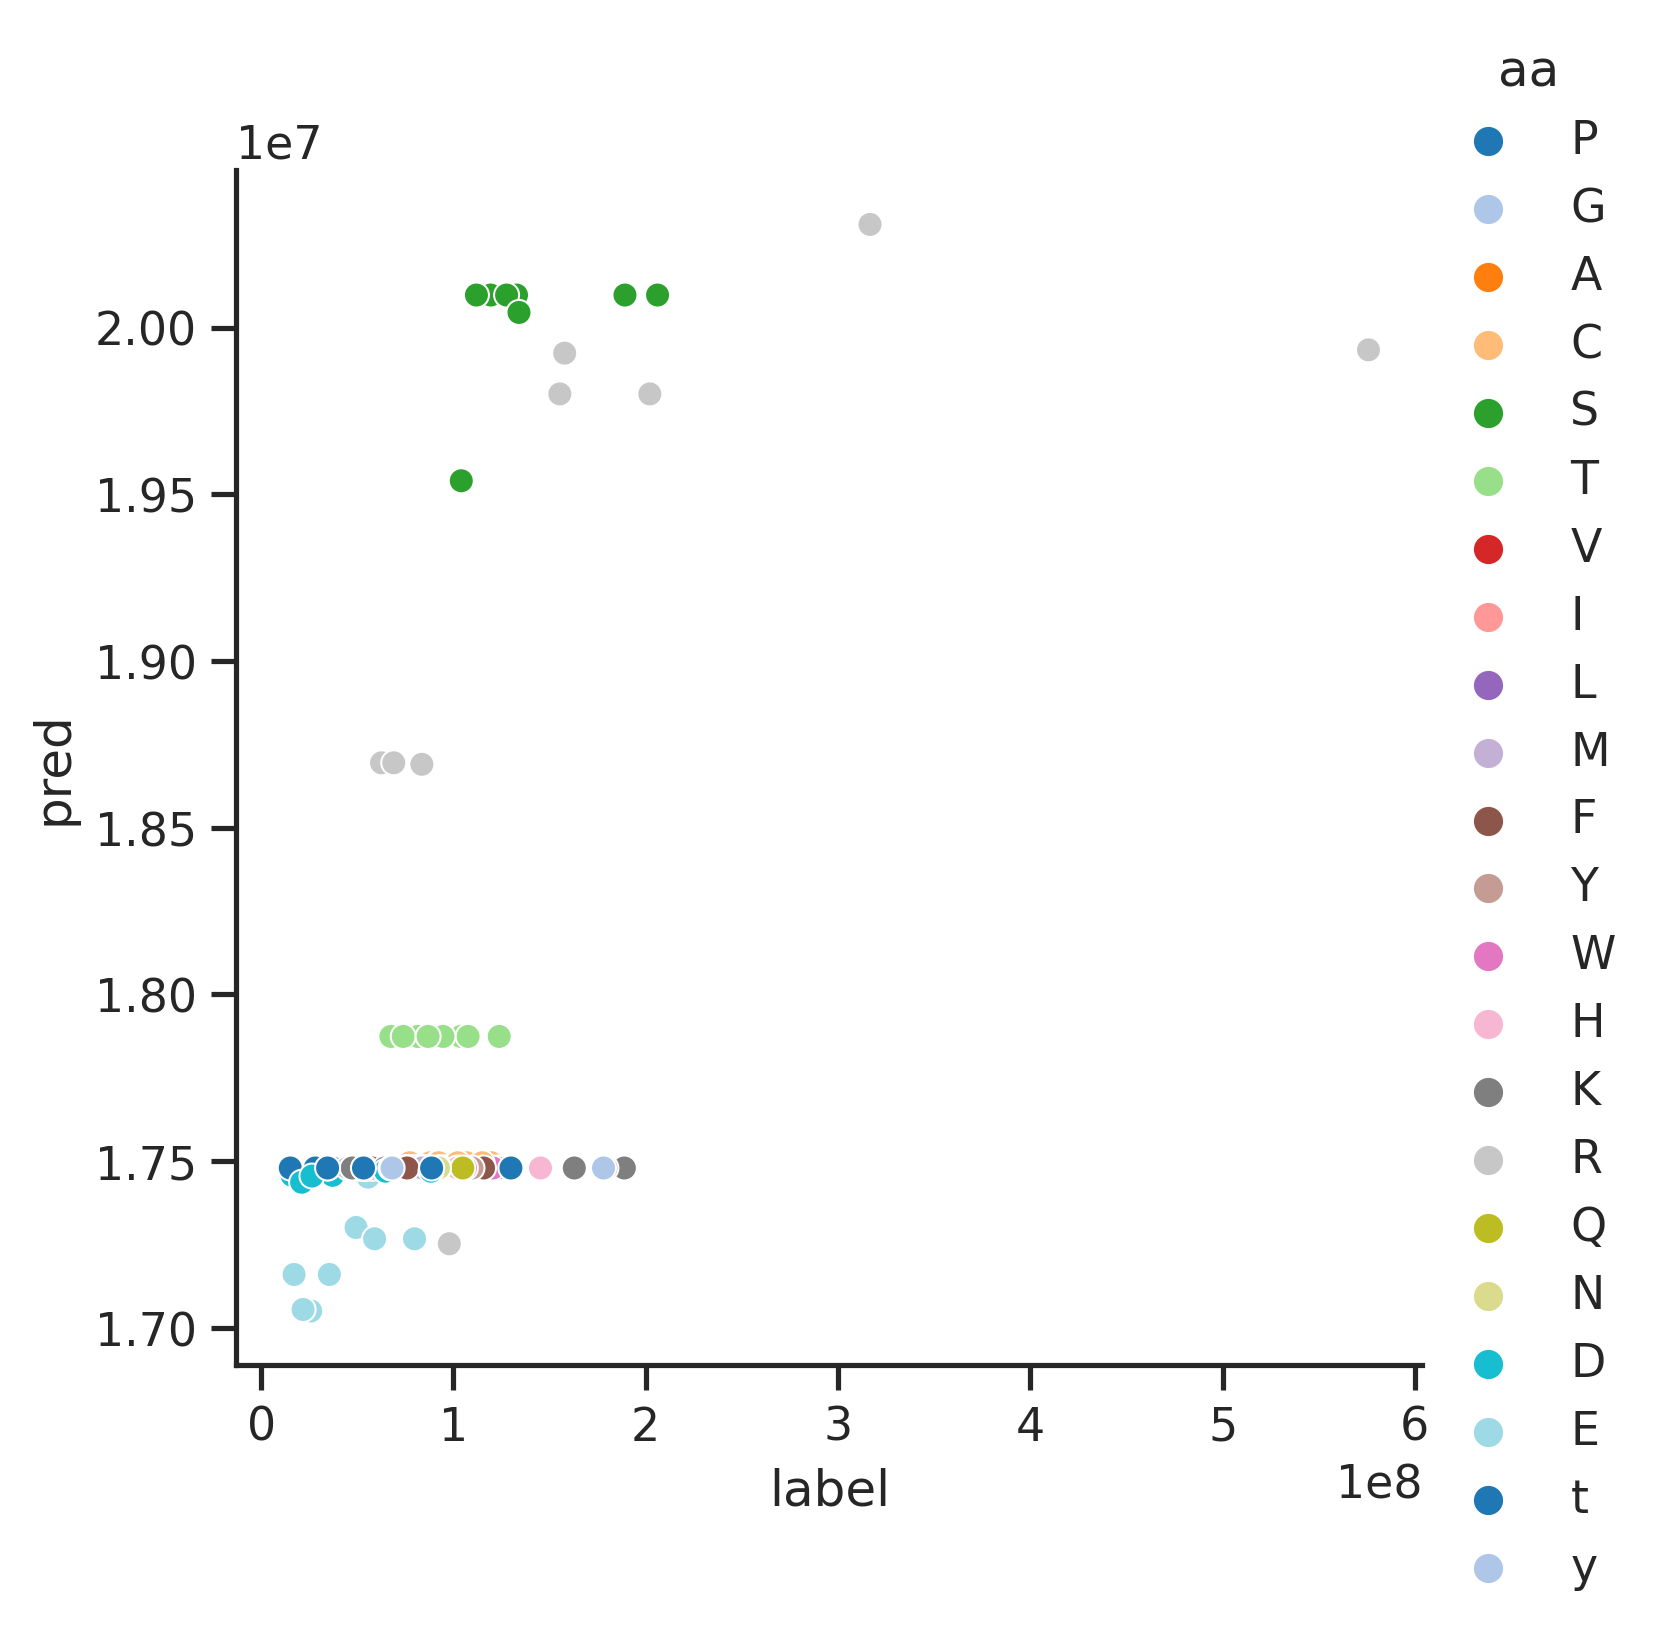

In [ ]:
sns.relplot(x = pred.query(f'kinase == "{k}"').label, 
            y = pred.query(f'kinase == "{k}"').pred, 
            hue = pred.query(f'kinase == "{k}"').aa, 
            palette = 'tab20' );

### Make it a whole report

This function is to check kinase with extreme correlation scores

In [ ]:
def kinase_report(pred, kinase):
    
    pred_stack = pred.pivot(values = 'pred',index='kinase',columns = 'substrate').reset_index()

    label_stack = pred.pivot(values = 'label',index='kinase',columns = 'substrate').reset_index()
    
    raw_stack = Data.get_kinase_raw()
    
    print(f'Logo of {kinase}  from raw dataset')
    raw2logo(raw_stack, kinase)

    print(f'Logo of {kinase}  from reversed label')
    raw2logo(label_stack, kinase);

    print(f'Logo of {kinase}  based on prediction')
    raw2logo(pred_stack, kinase)

    
    print('correlation')
    plot_corr(pred.query(f'kinase == "{kinase}"').label,
          pred.query(f'kinase == "{kinase}"').pred, 
          method='pearson')

    
    print('colored by aa')
    sns.relplot(x = pred.query(f'kinase == "{kinase}"').label, 
            y = pred.query(f'kinase == "{kinase}"').pred, 
            hue = pred.query(f'kinase == "{kinase}"').aa, 
            palette = 'tab20' )
    plt.show()
    plt.close()
    
    return pred_stack, label_stack

Logo of PAK3  from raw dataset


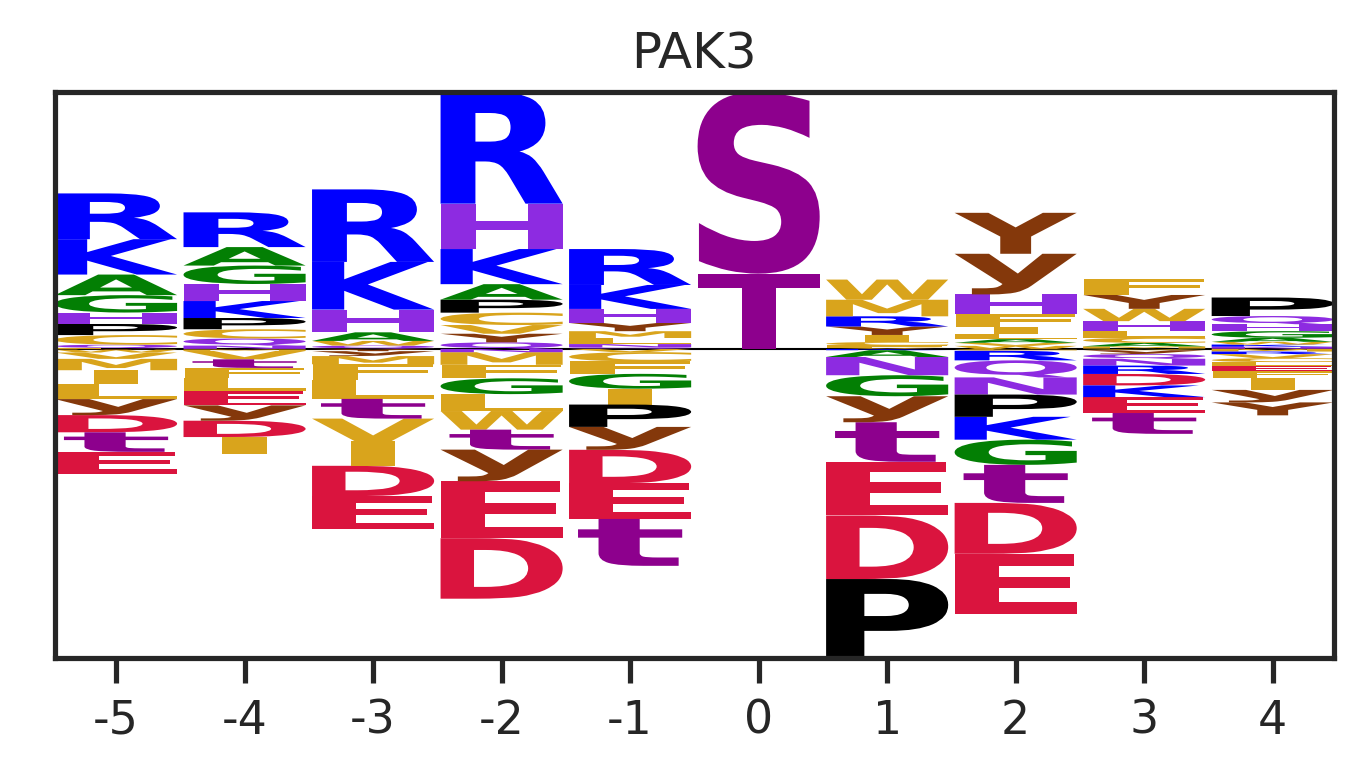

Logo of PAK3  from reversed label


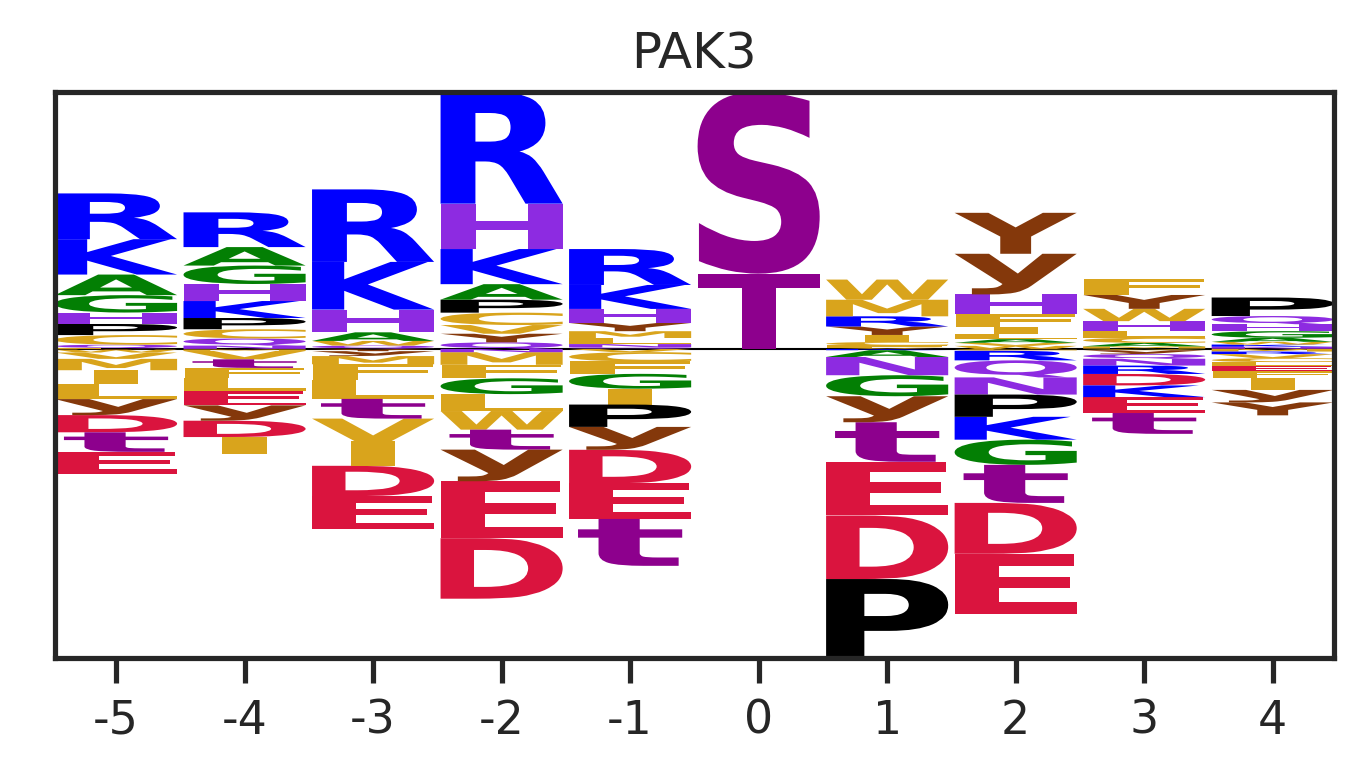

Logo of PAK3  based on prediction


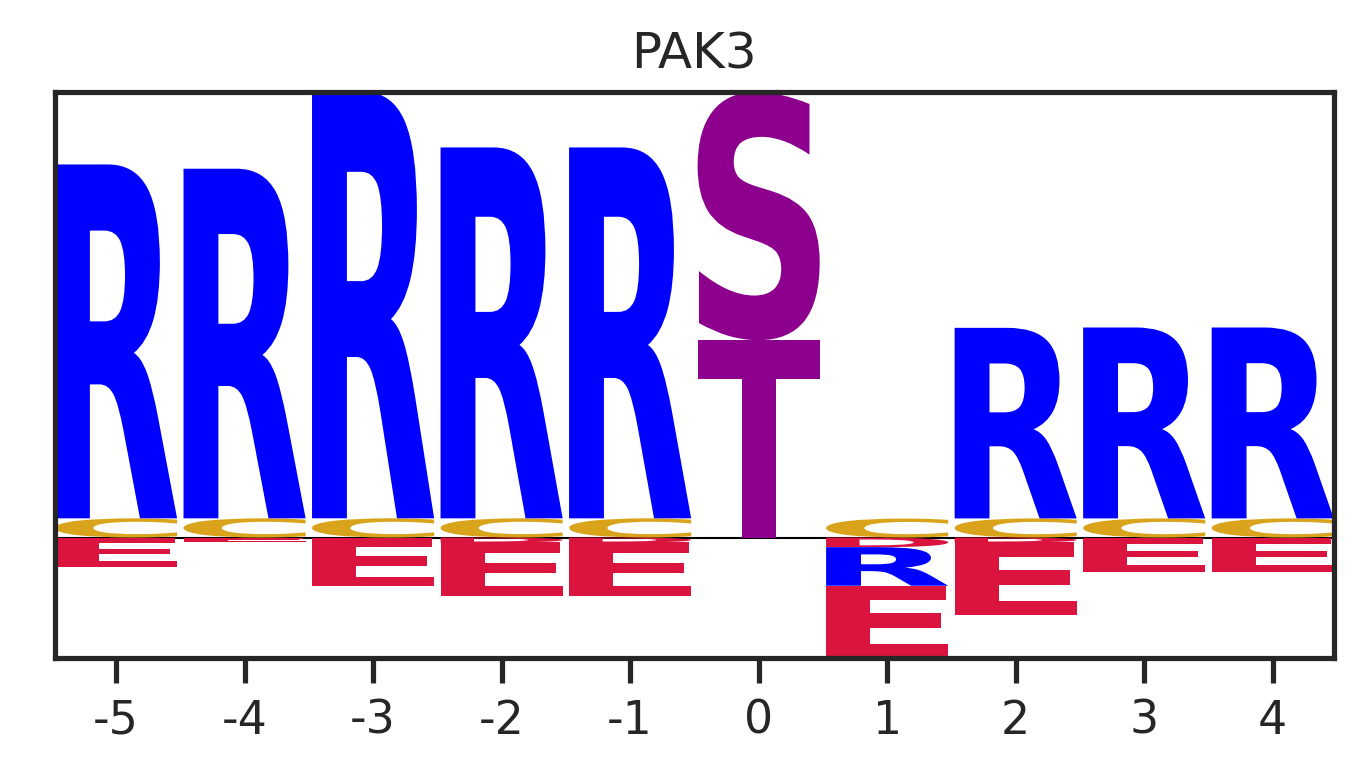

correlation


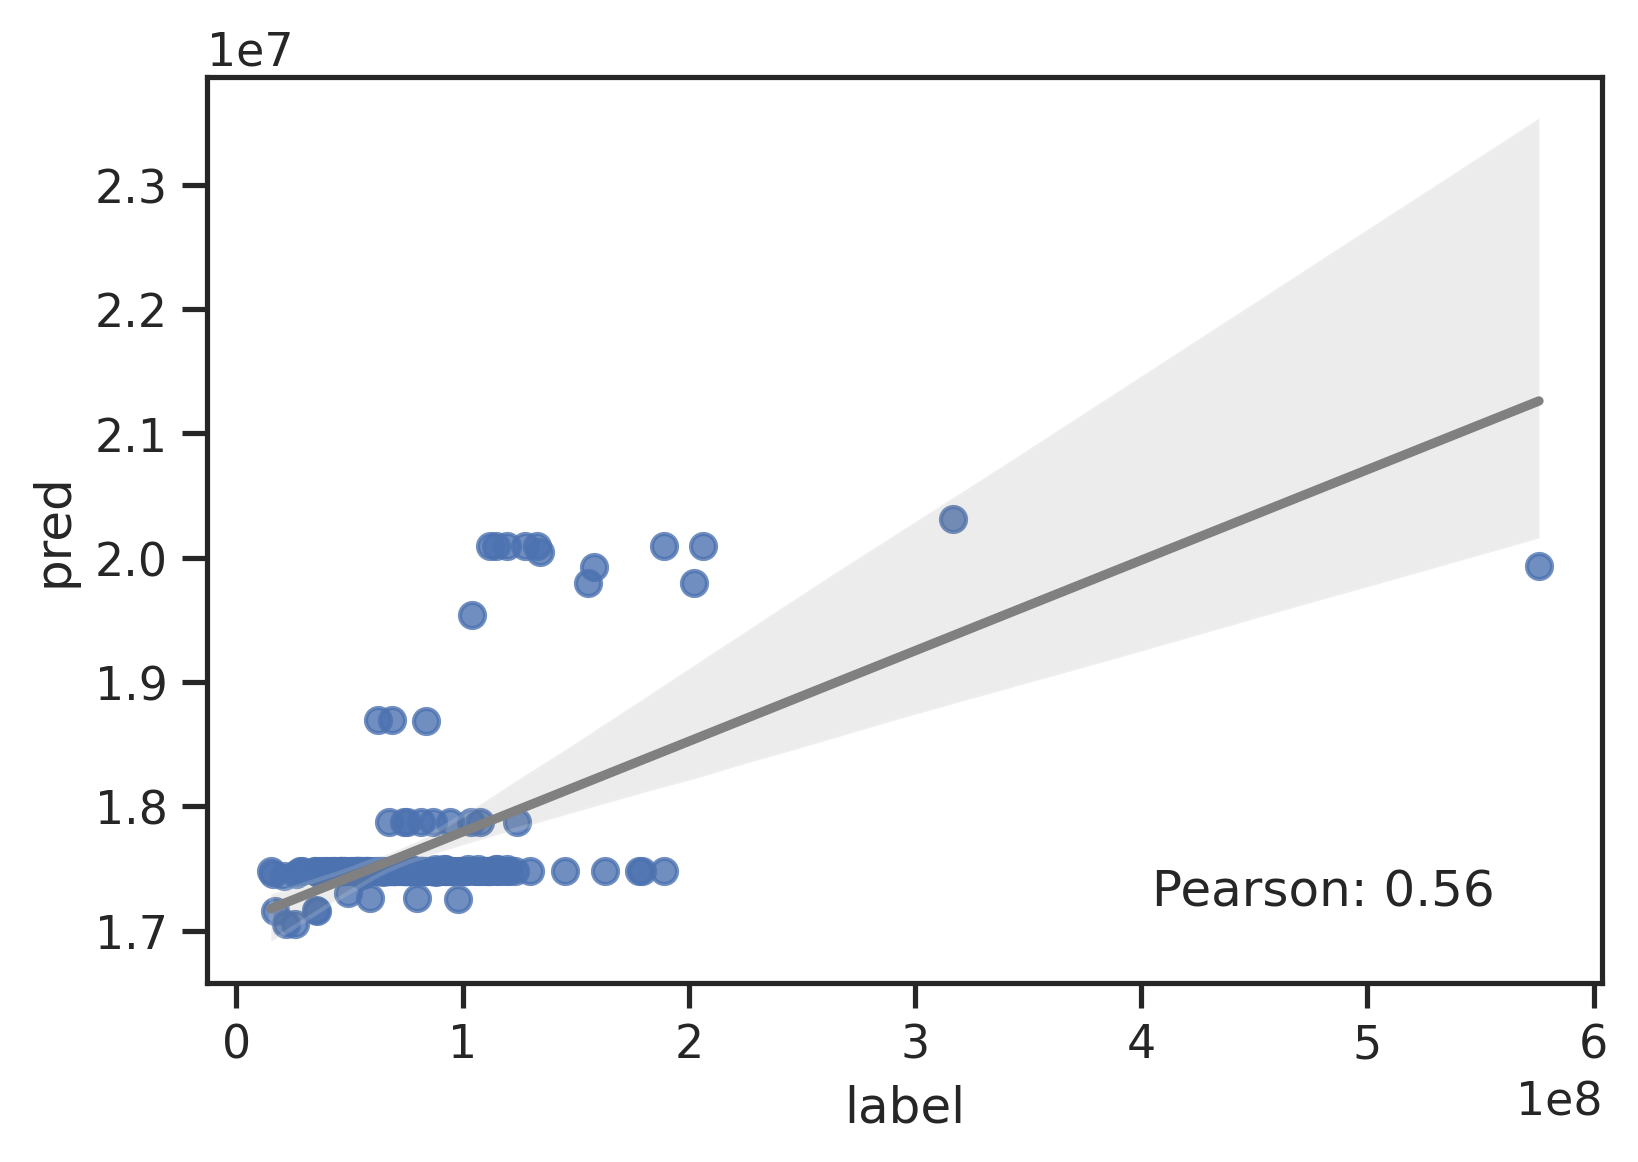

colored by aa


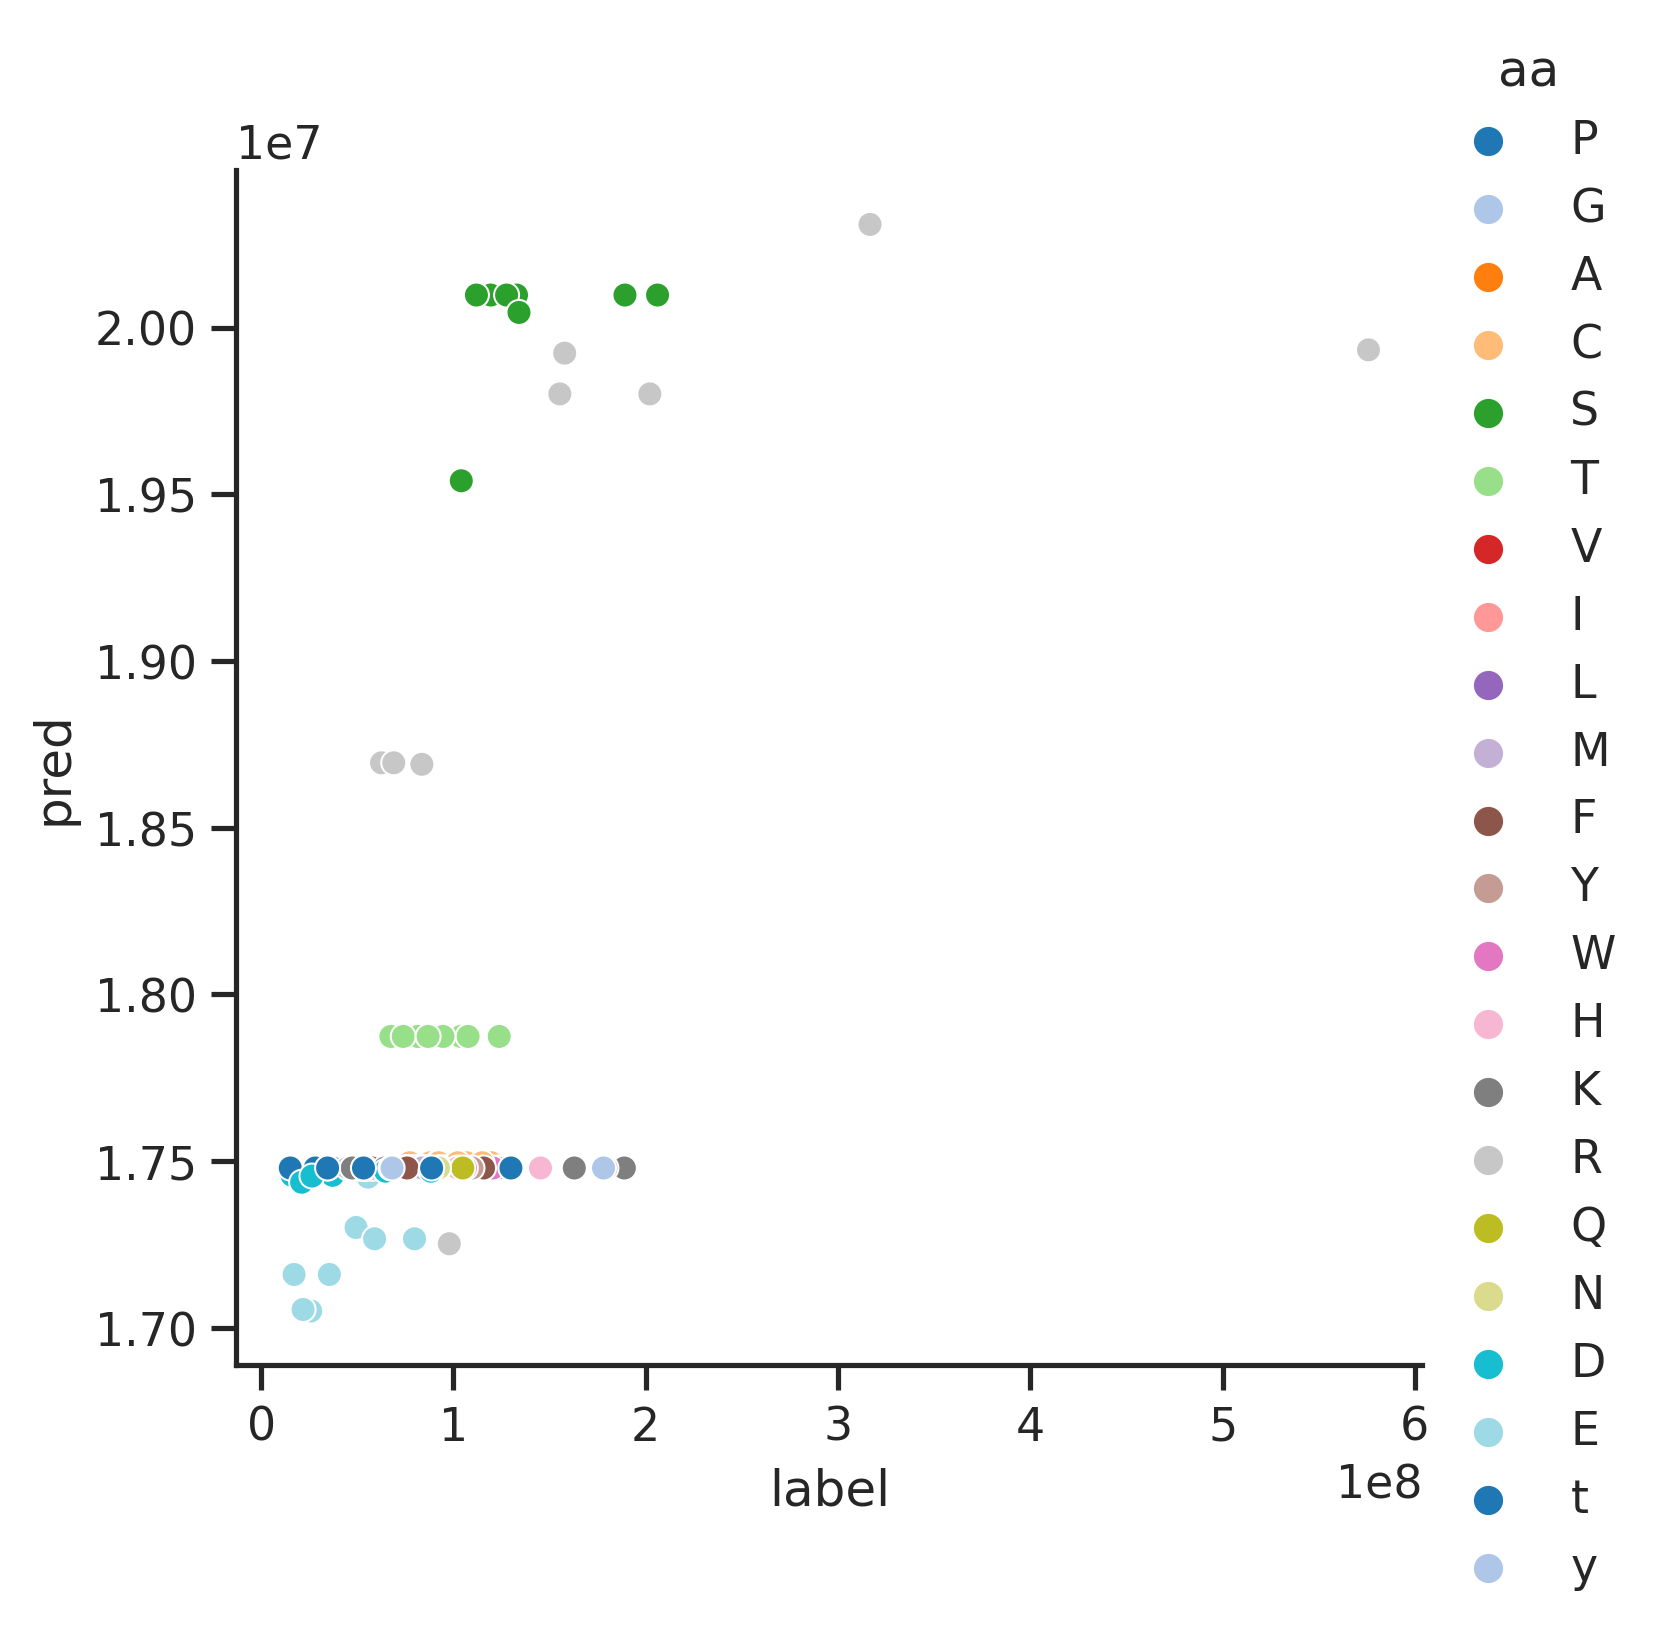

In [ ]:
pred_stack, label_stack = kinase_report(pred, 'PAK3')

## Analysis Pearson

In [ ]:
pred.groupby('kinase')[['label','pred']].corr()

label      pred
kinase                          
AAK1   label  1.000000  0.046731
       pred   0.046731  1.000000
AKT3   label  1.000000  0.498934
       pred   0.498934  1.000000
AMPKA2 label  1.000000  0.437443
...                ...       ...
TTBK2  pred   0.279192  1.000000
WNK4   label  1.000000  0.464968
       pred   0.464968  1.000000
YSK1   label  1.000000  0.297344
       pred   0.297344  1.000000

[122 rows x 2 columns]

In [ ]:
pearson = pred.groupby('kinase')[['label','pred']].corr().pred.loc[::2].reset_index()

In [ ]:
# Get the absolute value of pearson correlation, and name the column pearson
pearson['pearson'] = abs(pearson.pred)

In [ ]:
pearson.head()

,kinase,level_1,pred,pearson
0,AAK1,label,0.046731,0.046731
1,AKT3,label,0.498934,0.498934
2,AMPKA2,label,0.437443,0.437443
3,AURA,label,0.345644,0.345644
4,BMPR1A,label,-0.079943,0.079943


Collect information for this df

In [ ]:
pearson = pearson.merge(kinase_info, 'left')

In [ ]:
pearson.head()

,kinase,level_1,pred,pearson,Family,category,category_big
0,AAK1,label,0.046731,0.046731,Other,NAK,NAK
1,AKT3,label,0.498934,0.498934,AGC,AKT/ROCK,basophilic
2,AMPKA2,label,0.437443,0.437443,CAMK,AMPK,basophilic
3,AURA,label,0.345644,0.345644,Other,AURK/PKA,basophilic
4,BMPR1A,label,-0.079943,0.079943,TKL,TGFBR,acidophilic


In [ ]:
print(f'The average pearson value across kinases in valid set is : {pearson.pearson.mean().round(4)}')

The average pearson value across kinases in valid set is : 0.3141


In [ ]:
pearson.sort_values('pearson')

,kinase,level_1,pred,pearson,Family,category,category_big
13,CK1D,label,-0.008844,0.008844,CK1,CK1,acidophilic
20,GRK1,label,0.023146,0.023146,AGC,GRK,acidophilic
14,CK2A2,label,-0.043144,0.043144,Other,CK2,acidophilic
0,AAK1,label,0.046731,0.046731,Other,NAK,NAK
21,GRK6,label,0.059290,0.059290,AGC,GRK,acidophilic
...,...,...,...,...,...,...,...
1,AKT3,label,0.498934,0.498934,AGC,AKT/ROCK,basophilic
33,MRCKB,label,0.499352,0.499352,AGC,AKT/ROCK,basophilic
49,PRKD2,label,0.505126,0.505126,CAMK,PRKD/MAPKAPK,basophilic
47,PKN2,label,0.531650,0.531650,AGC,ALPHA/MLK,ALPHA/MLK


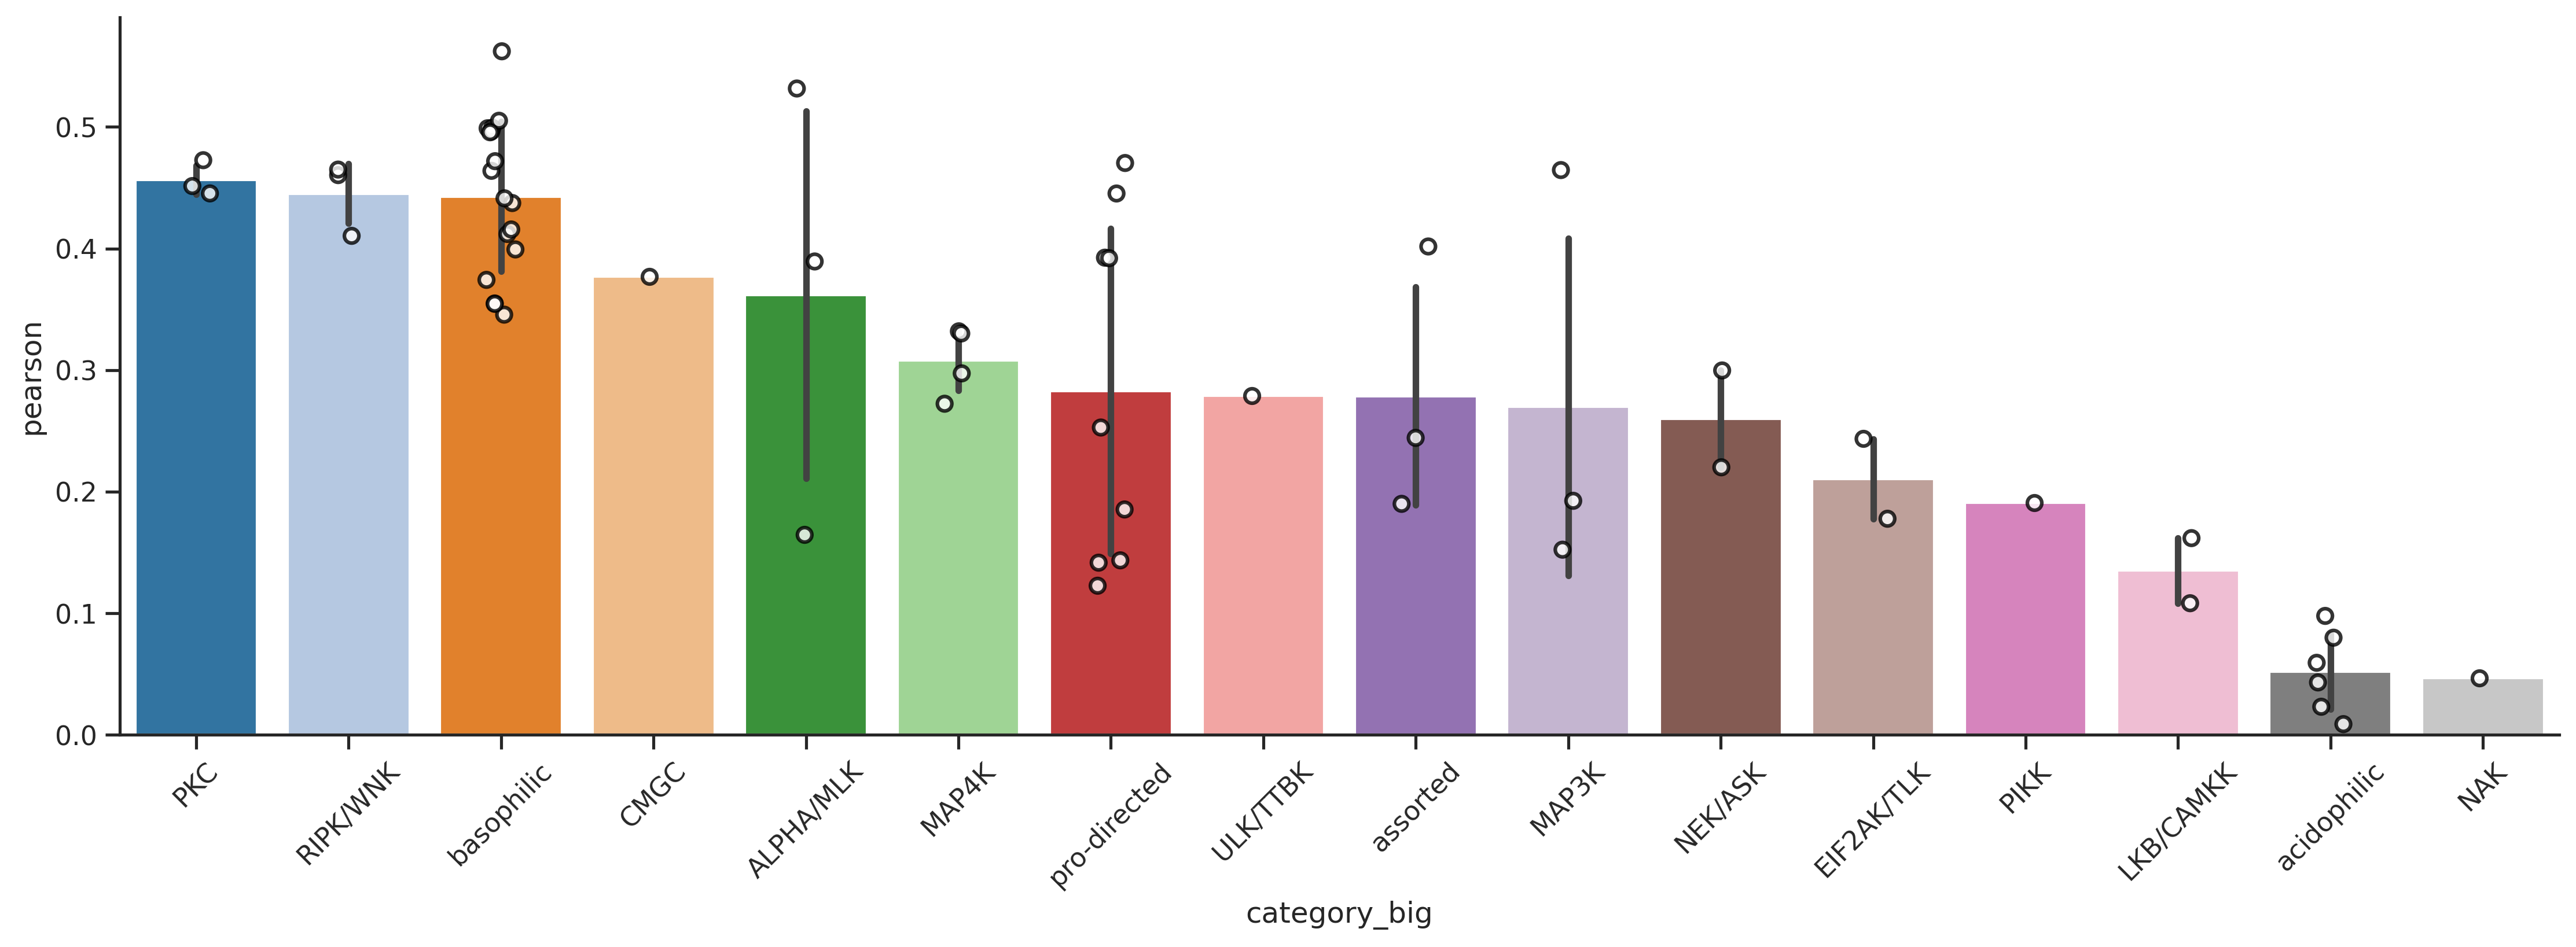

In [ ]:
plot_bar(pearson,'pearson','category_big')

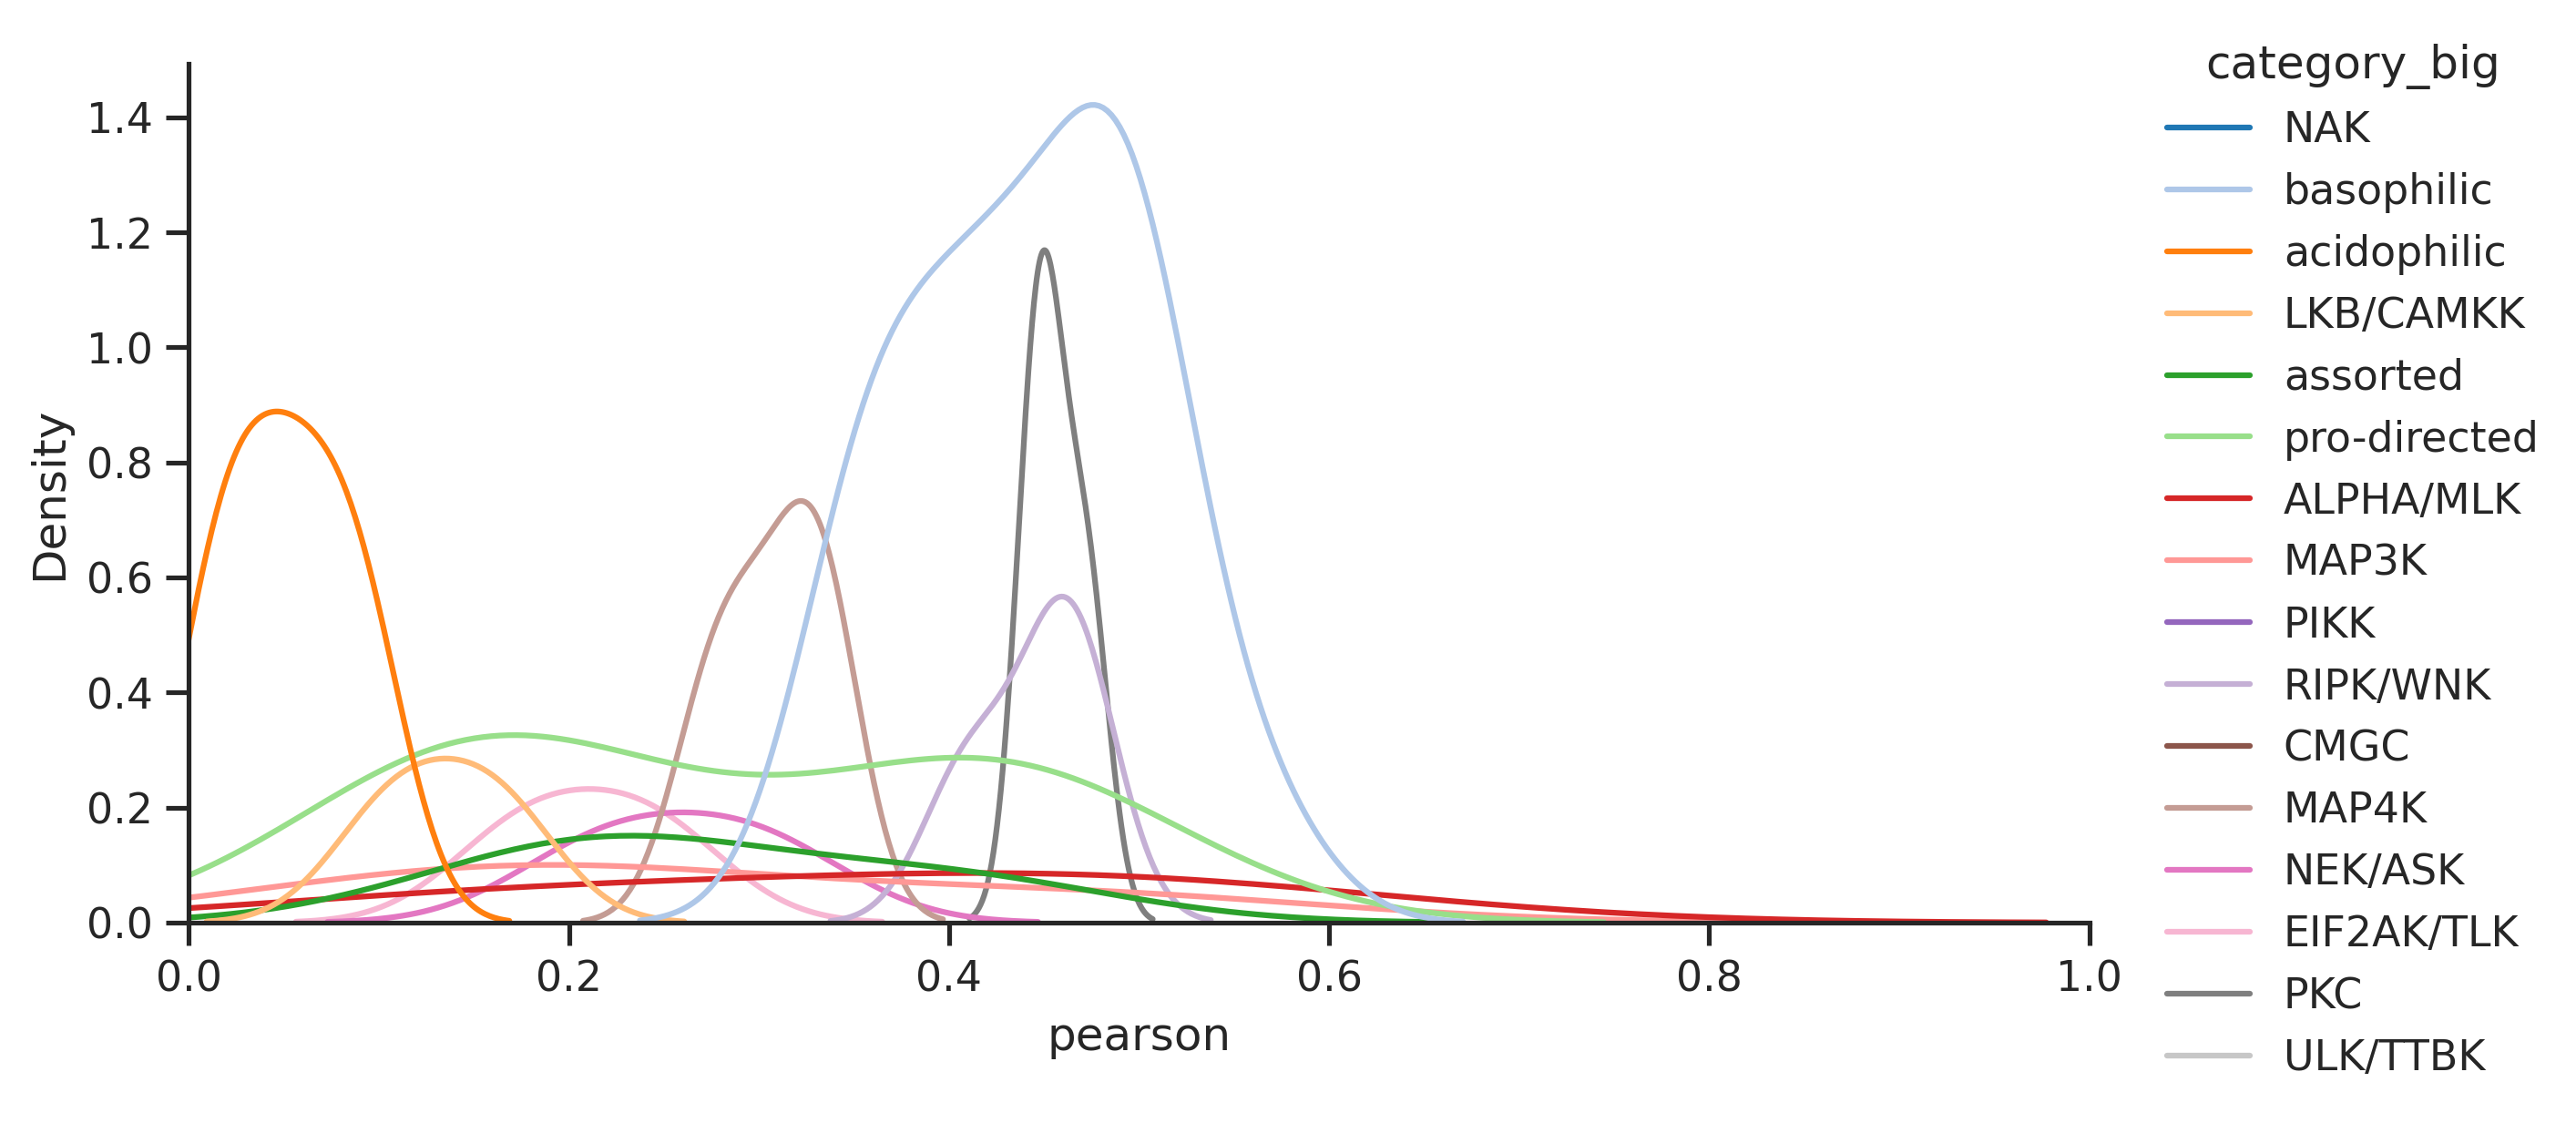

In [ ]:
sns.displot(pearson,
            x = 'pearson',
            aspect=2,
            kind='kde',
            hue = 'category_big',
            palette = 'tab20',
            height=4,
            warn_singular=False
           ).set(xlim=(0,1));

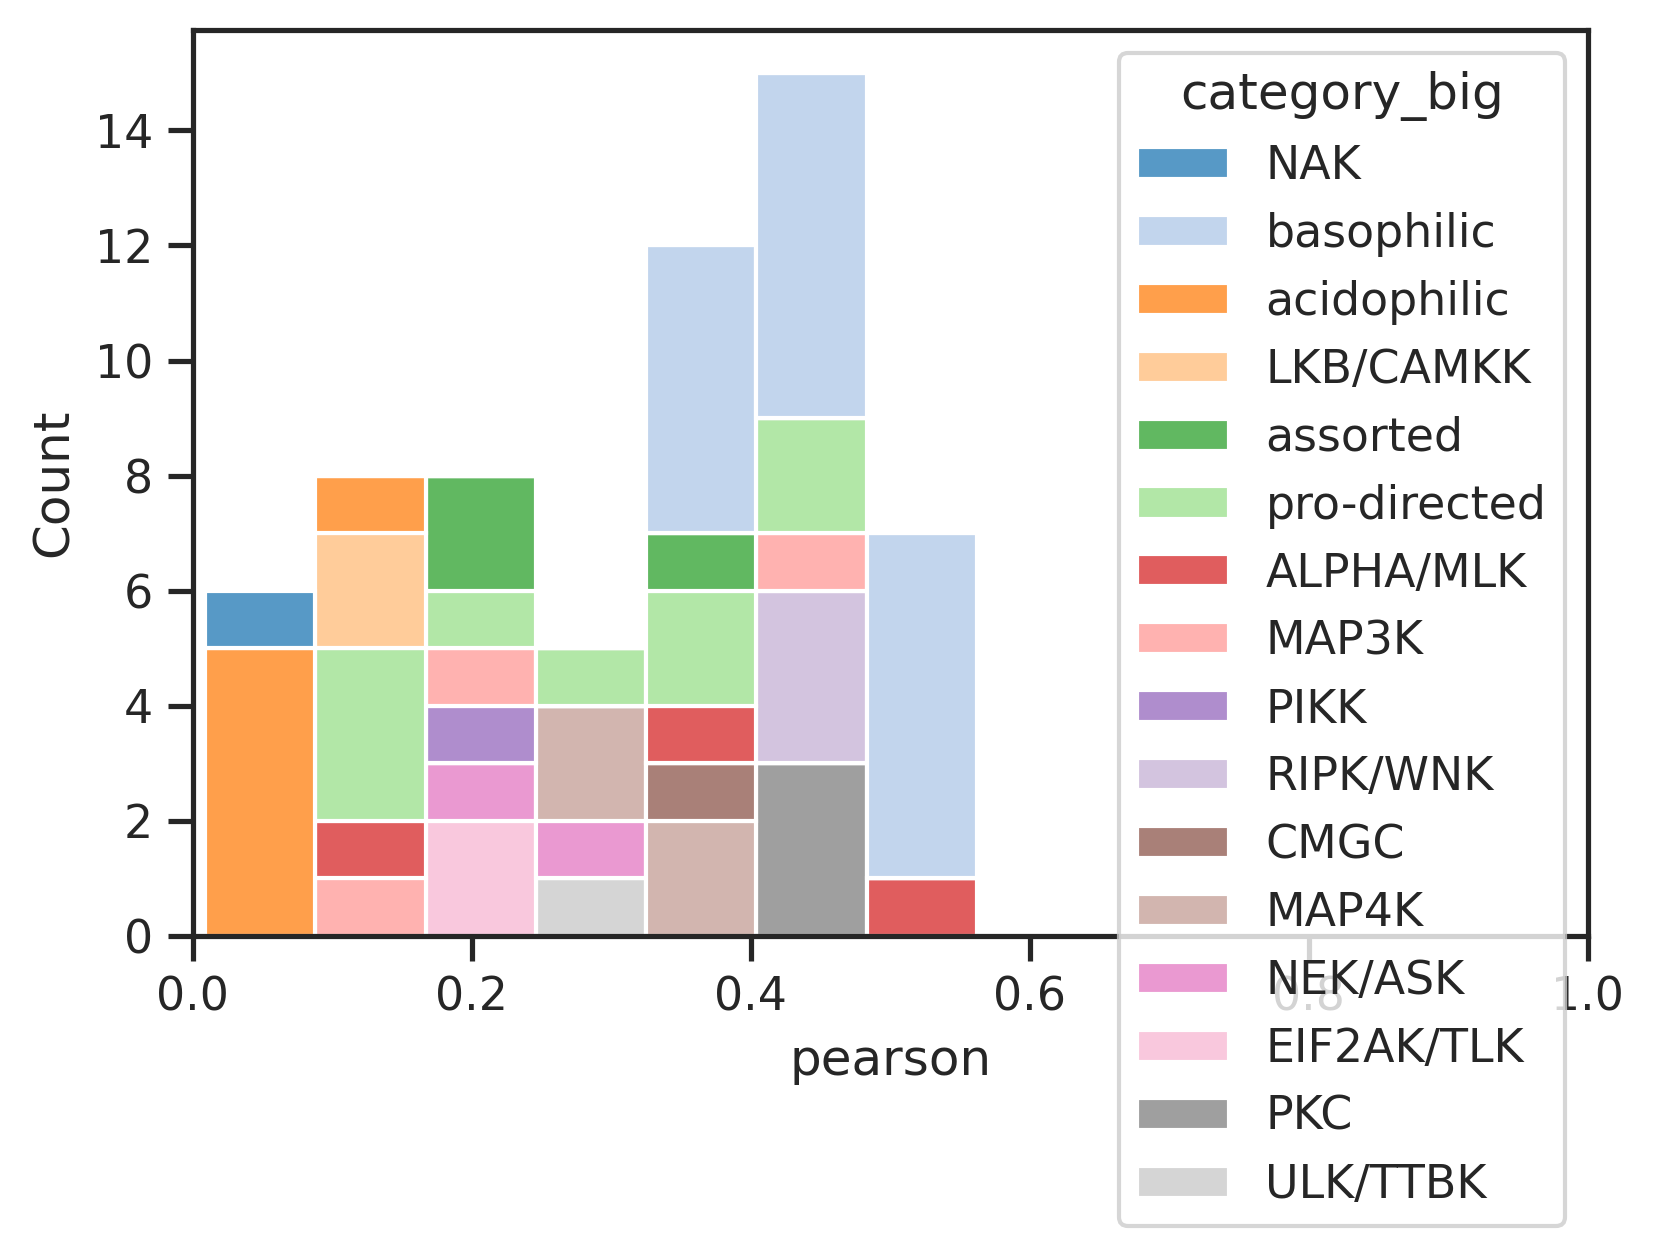

In [ ]:
sns.histplot(data=pearson,
             x='pearson',
             hue='category_big',
             palette='tab20',
             multiple='stack',
            ).set(xlim=(0, 1));